# **EE2ML1: Introduction to Machine Learning**
# Assignment Week 4 (Midterm Project): ECG Classification

This notebook is structured like a scientific paper. The text should provide a high-level overeview of your approach. Please don't include any details about your codes in the text but add them as comments in the code itself. Your code should be clean and readable with enough comments. You can use any python libraries you like. Here is also a [sklearn cheatsheet](https://colab.research.google.com/drive/12h-QBlsaWXkjGIRoJXfF4yqi1elnX9qn?usp=sharing) where you can find ML algorithms and functions similar to what you developed yourself in sk-learn. You should use these functions rather than what you developed yourself as these perform better and are more efficient. To help you get started we have completed parts of this notebook. However, you can change them and adapt it to your pproach if you wish. In your final submission remove all texts highlighted in blue (they are just some guidlines for you) and replace them with your own text and description. Such that the notebook looks like a clean and coherent paper/report.



## I. Introduction
Cardiac abnormalities are the most leading causes of
death in the world. However, an early detection of these abnormalities can increase the chance of successful treatment and decrease the mortality
rate. The standard electrocardiogram (ECG) recording is the
most common diagnosing tool used for detection of a variety of cardiac abnormalities. This study proposes a feature engineering
based machine learning algorithm to classify between normal sinus rhythm (NSR) and two abnormalities: arrhythmia (ARR) and congestive heart failure (CHF).
The approach focuses on feature engineering, with
special attention to rhythm and morphological changes induced
by the abnormalities. The remainder of this study is organized as follows. In Section II we focuse on our methods including an introduction to the dataset, preprocessing techniques, R-peak detection, feature extraction, feature selection and classification. In Section III we present our results and finally in Section IV we discuss our approach and conclude the study.


## II. Methods


### II.1 Data

In this study we use the dataset provided on MATLAB [GitHub repository](https://github.com/mathworks/physionet_ECG_data/). The data is originally from 3 different [PhysioNet](https://physionet.org) datasets.
The dataset includes 162 ECG recordings in total. There are 96 recordings from persons with arrhythmia, 30 recordings from persons with congestive heart failure, and 36 recordings from persons with normal sinus rhythms. The following processing steps were applied (by MATLAB) to each raw data file in the three PhysioNet databases to construct the data in ECGData.Data:

1.   The scaling defined in the PhysioNet .info files for each PhysioNet data file was applied to each raw data file.
2.   The data were resampled to a common rate of 128 hertz.
3.  Each data file consisting of two ECG recordings was separated into two separate data records.
4. The data length was truncated to a common length of 65536 samples.


In [ ]:
# Load dataset directly from MATLAB GitHub
import sys
import os

if not os.path.exists(os.getcwd()+'/physionet_ECG_data'):
    !git clone https://github.com/mathworks/physionet_ECG_data.git
else:
    print('folder already exists!')

Cloning into 'physionet_ECG_data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12 (delta 1), reused 5 (delta 1), pack-reused 6
Unpacking objects: 100% (12/12), 66.87 MiB | 8.99 MiB/s, done.


In [ ]:
# unzip files
!unzip physionet_ECG_data/ECGData.zip

# converts .mat data to numpy arrays
import scipy.io
# Import to a python dictionary
mat = scipy.io.loadmat('ECGData.mat')
# loading data and labels into x and y  numpy arrays
x=mat['ECGData']['Data'].item()
y=mat['ECGData']['Labels'].item()

Archive:  physionet_ECG_data/ECGData.zip
  inflating: License.txt             
  inflating: Modified_physionet_data.txt  
  inflating: ECGData.mat             


### II.2. preprocessing
Breathing artifacts, electromyography interference,
and power-line are inevitable noises on the ECG
recordings. Therefore, a preprocessing stage is needed to remove the
base-line wander, high- and low- frequency artifacts to
to improve the quality of the signals. To do, we use a bandpass
2nd order Butterworth filter with the cut-off frequencies
of 0.5 Hz and 40 H, respectively.

In [ ]:
# bandpass filter the data for all 162 ECG recordings
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

def butter_bandpass(lowcut, highcut, sample_rate, order=2):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Define the cut-off frequencies and resample rate
lowcut = 0.5
highcut = 40
fs = 128

# Apply the bandpass filter to the last 5 ECG recordings from the 162 samples
for i in range(162):
    # Extract all the unfiltered data from the dataset
    ecg_unfiltered = x[i-1,:15300]

    # Filter all the ECG data with a bandpass filter
    b, a = butter_bandpass(lowcut, highcut, fs, order=2)
    ecg_filtered = filtfilt(b, a, ecg_unfiltered)

    # Plot filtered and unfiltered data in a random range
    #plt.plot(range(500,900), ecg_unfiltered[500:900])
    #plt.plot(range(500,900), ecg_filtered[500:900])
    #plt.title(f"ECG Data {i}")
    #plt.show()

### II.3. R-peak Detection
Rythm related features are important indicators of abnormality in the heart. To investigate these features,  we first need to detect  R peaks in each ecg recording. To do so, we use the Pan Tompkins algorithm provided by an open access software [Popular ECG R peak detectors written in python](https://zenodo.org/record/3588108#.YBBVkC1Q1KM).  



In [ ]:
# install ecgdetectors
!pip install py-ecg-detectors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.5/554.5 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43804 sha256=77ca28d8da32437fd8f1ef164e883672a38b37ff3932e59f66772ca9cf2c16cb
  Stored in directory: /root/.cache/pip/wheels/13/39/c2/d113611d276bf55252ed5a640e98596d7dcc96535afbf254d5
Successfully built gatspy


<ipython-input-6-806afd3f5c2c>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


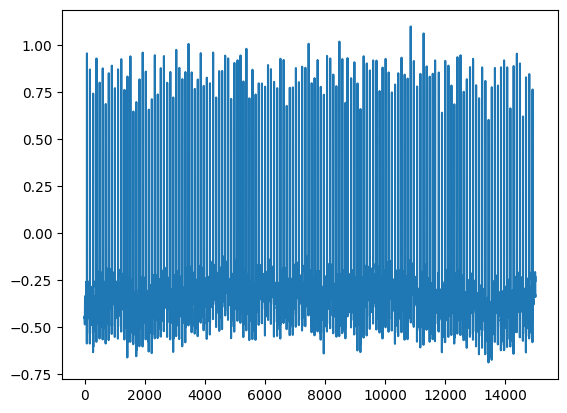

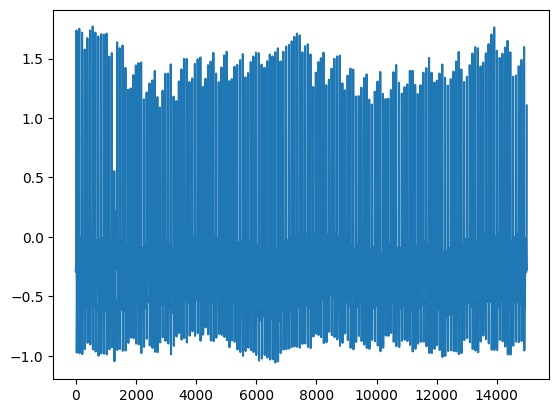

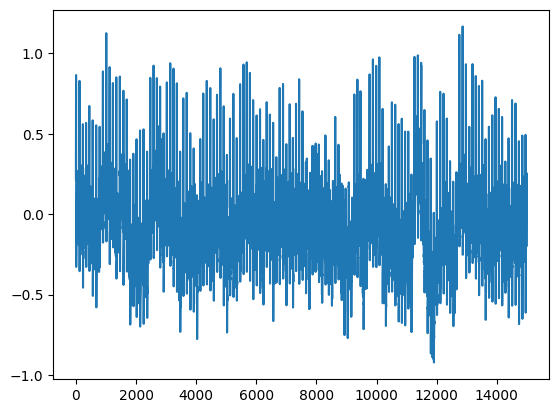

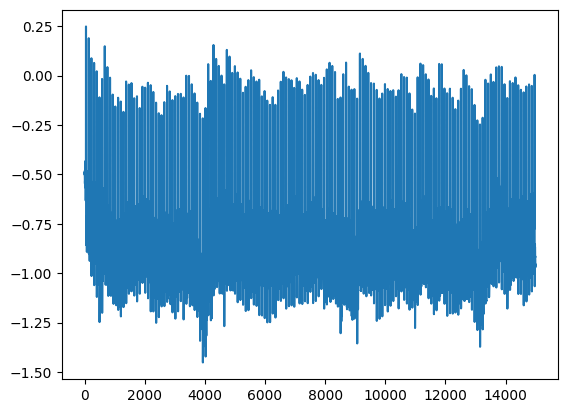

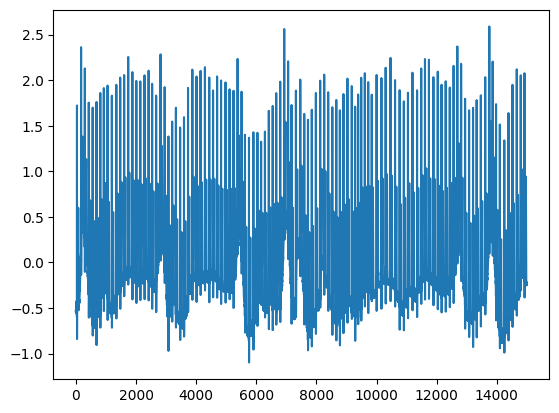

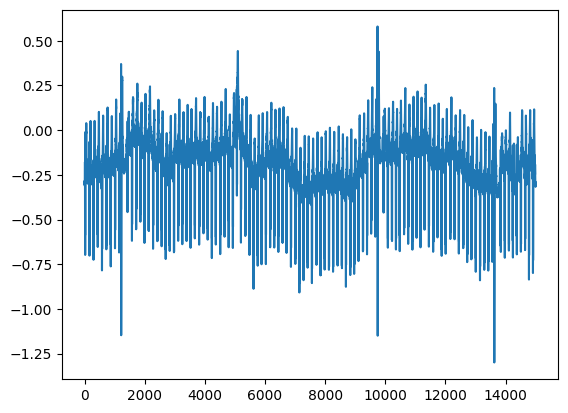

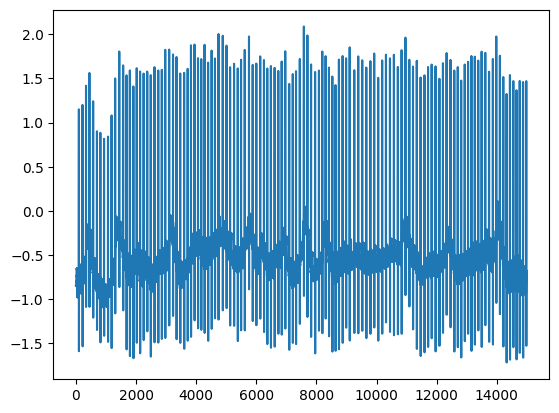

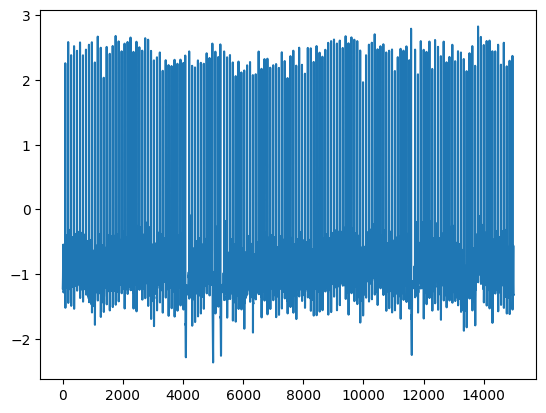

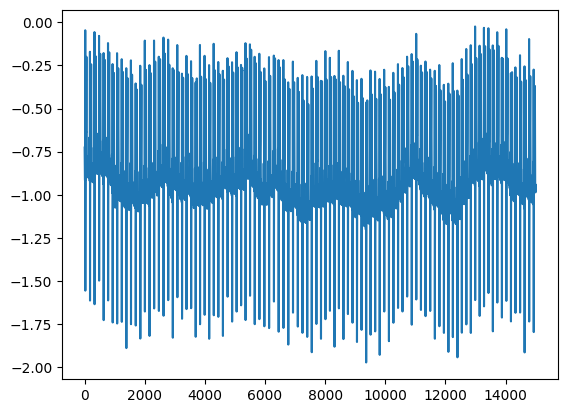

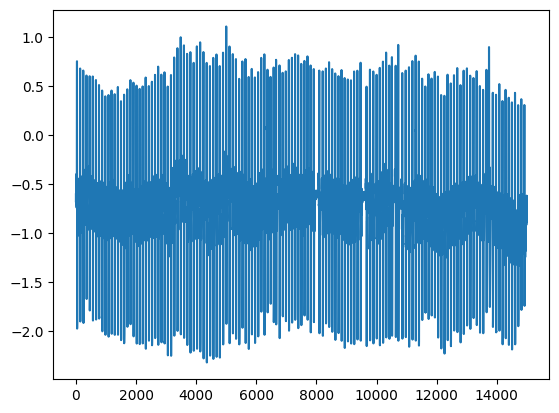

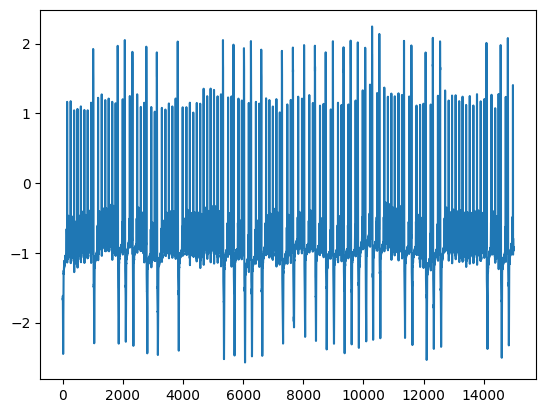

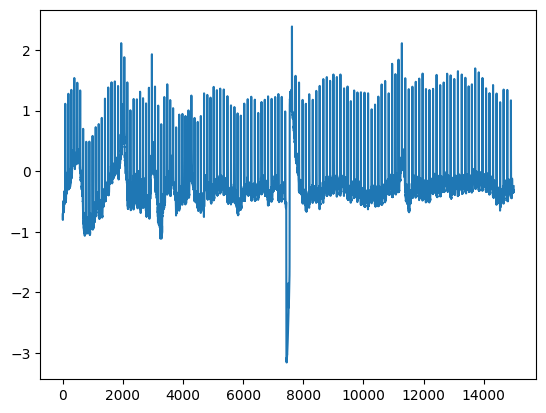

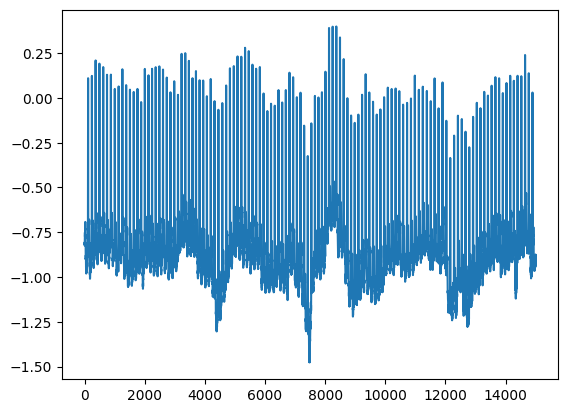

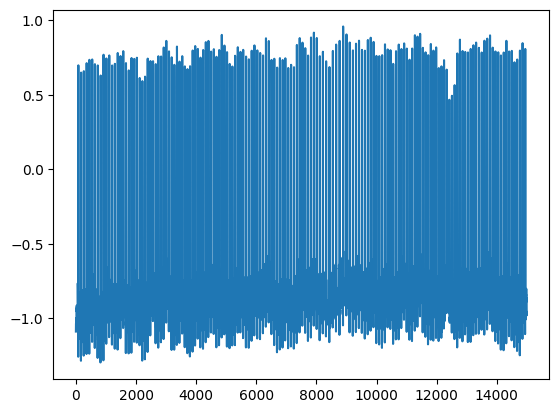

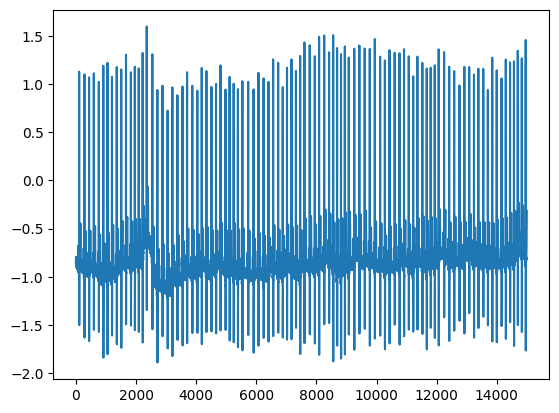

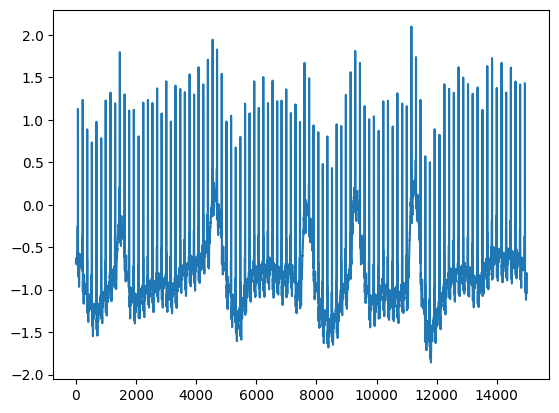

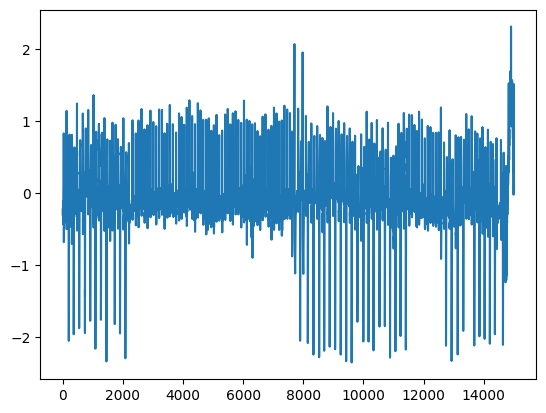

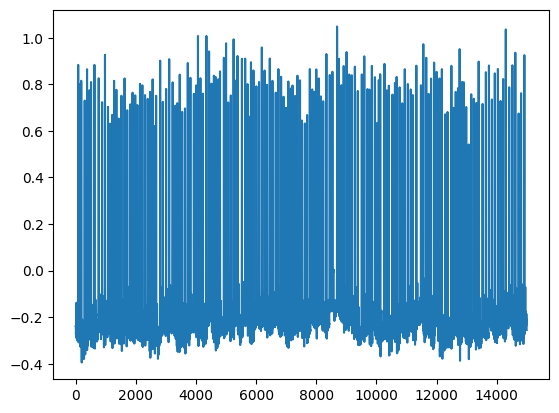

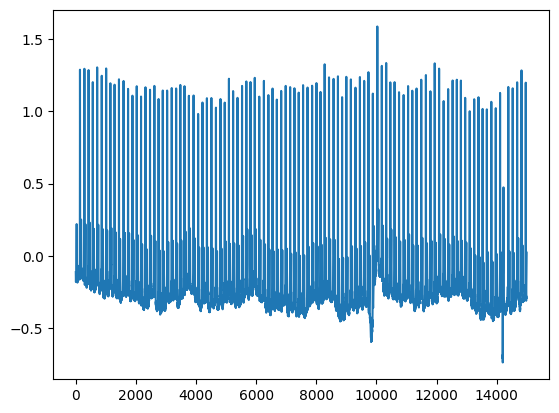

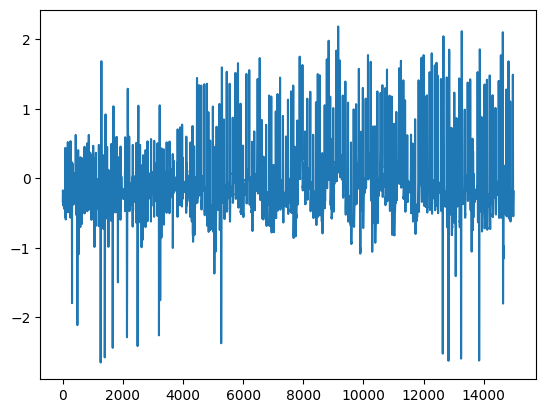

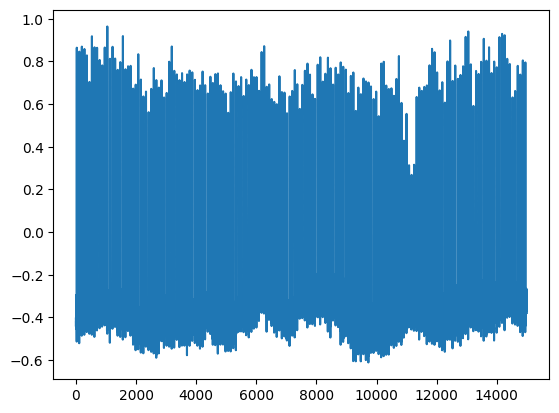

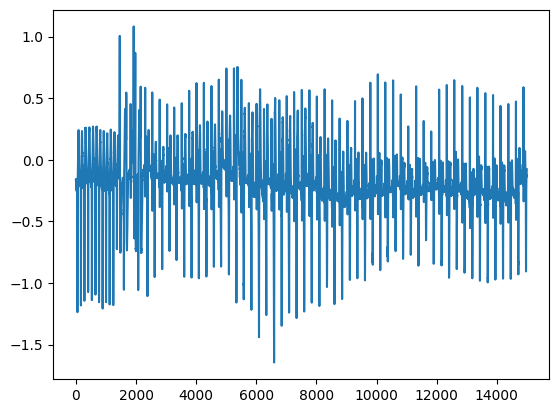

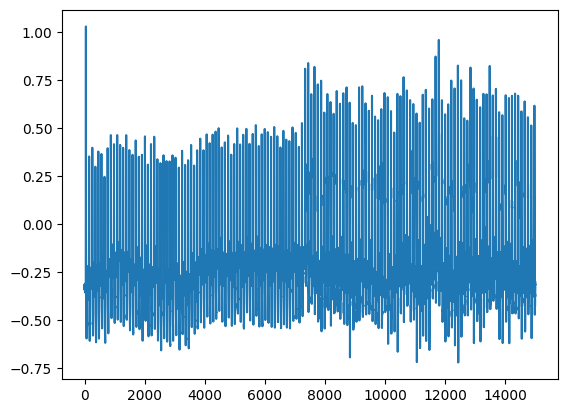

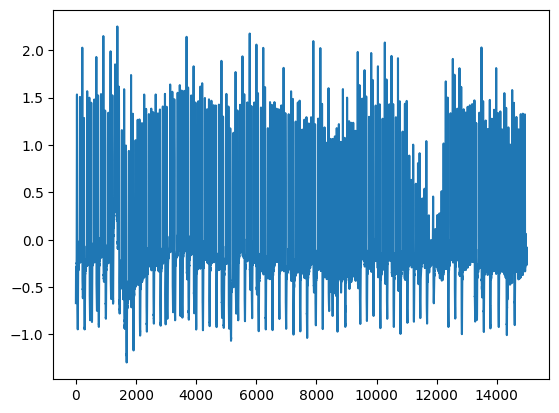

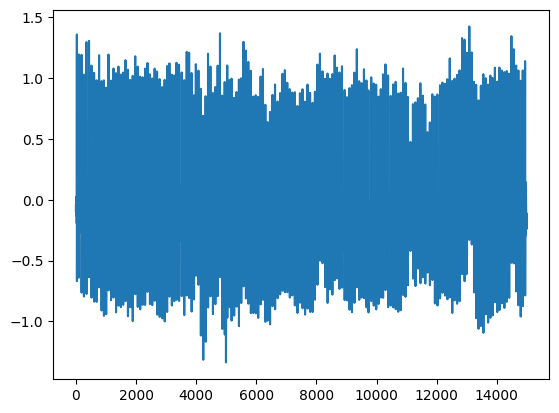

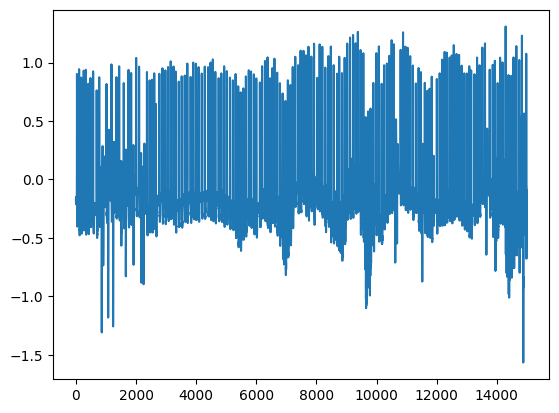

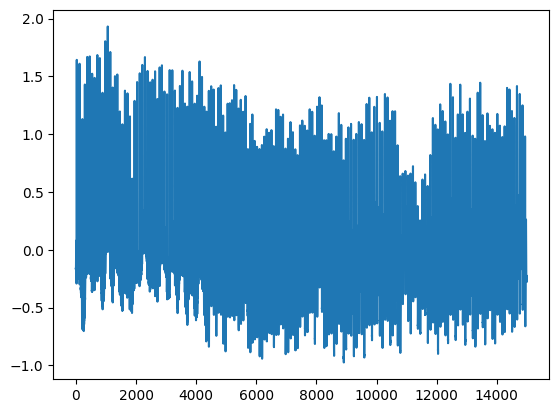

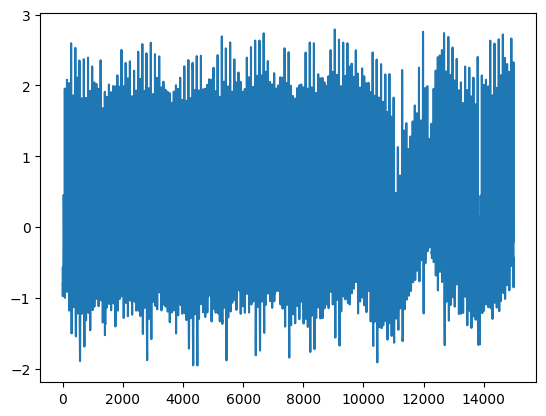

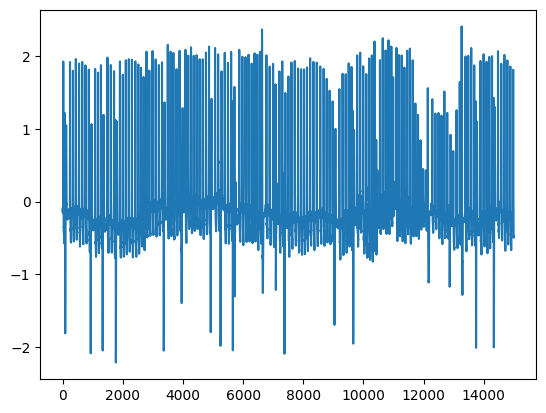

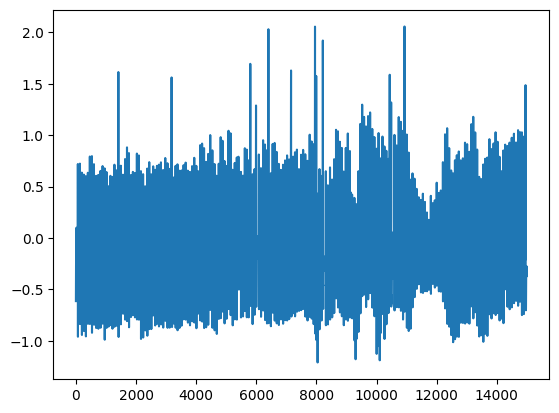

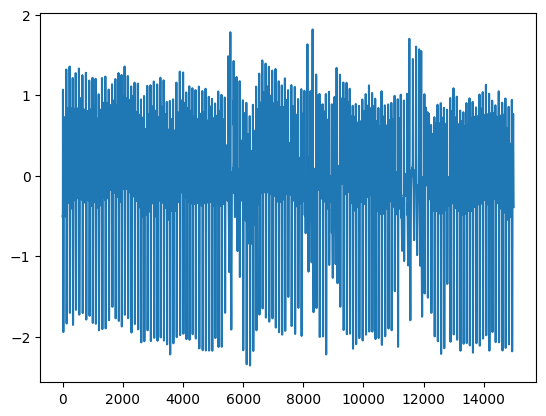

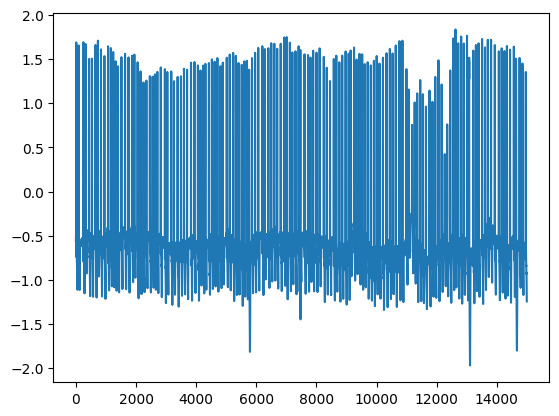

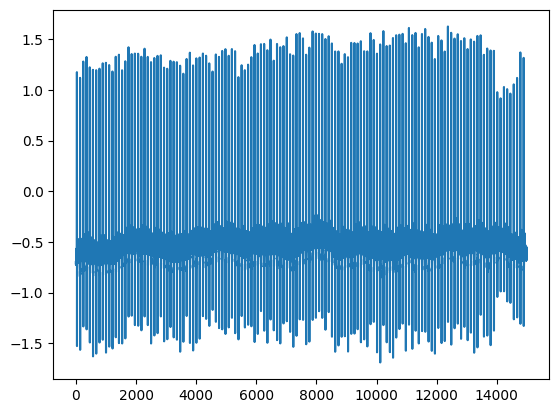

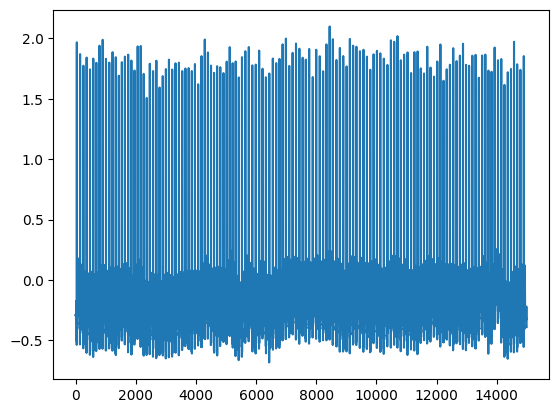

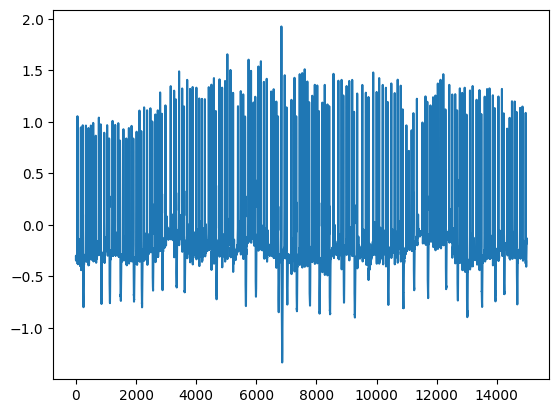

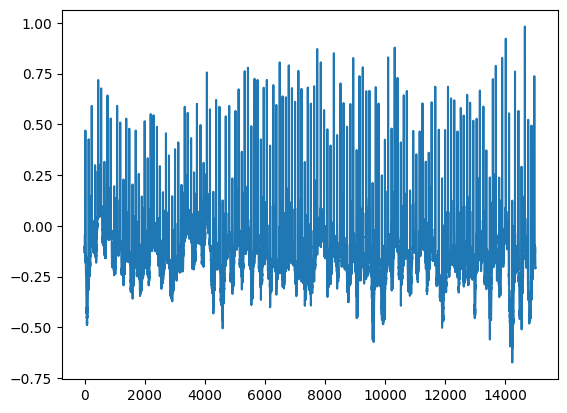

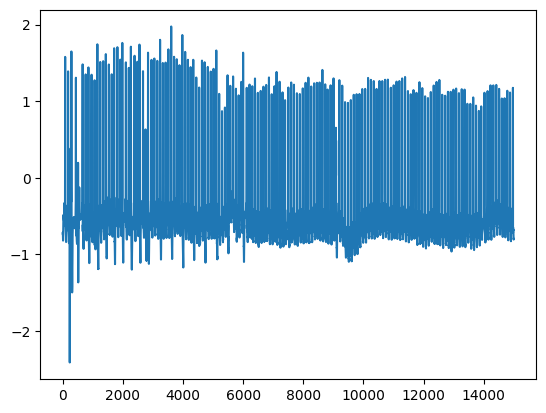

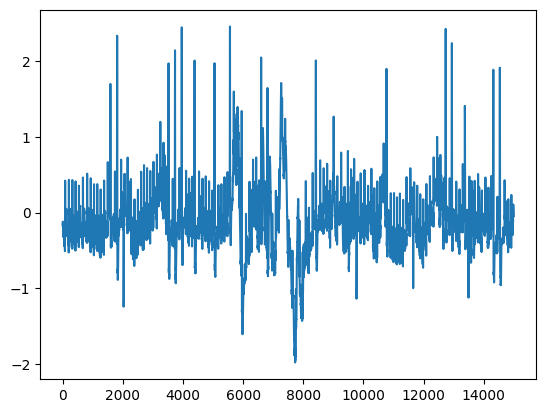

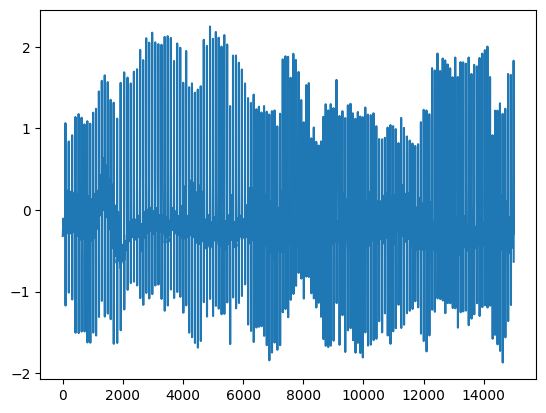

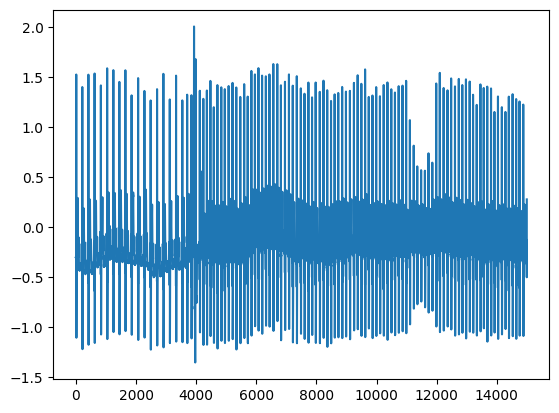

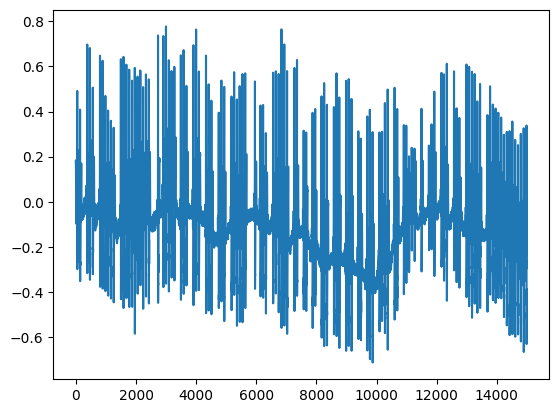

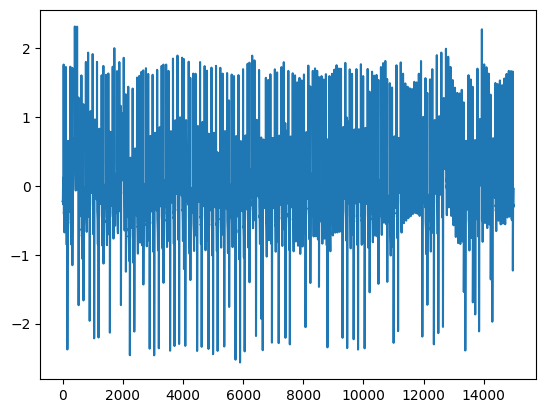

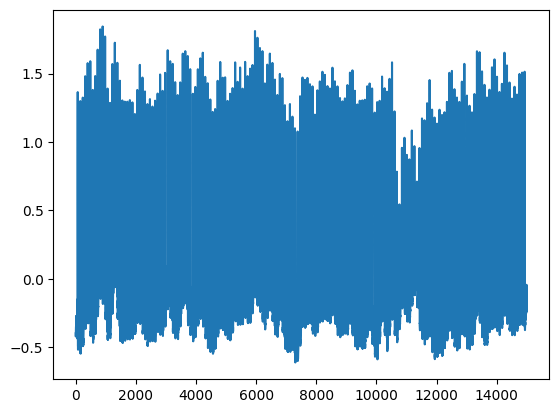

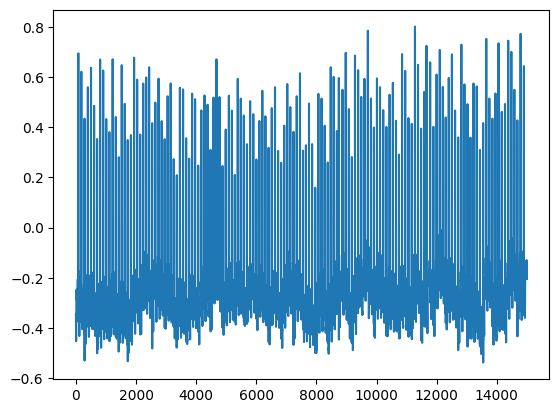

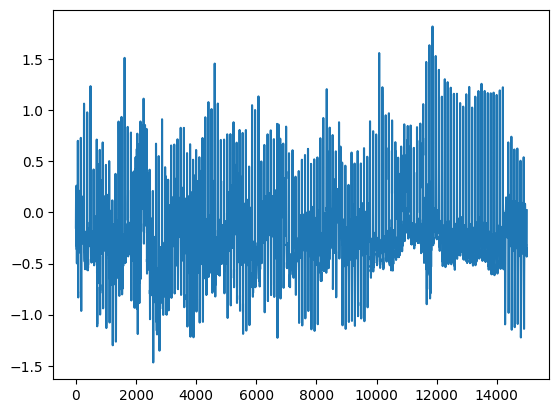

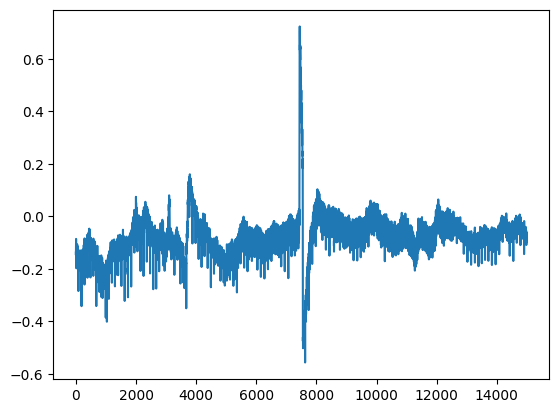

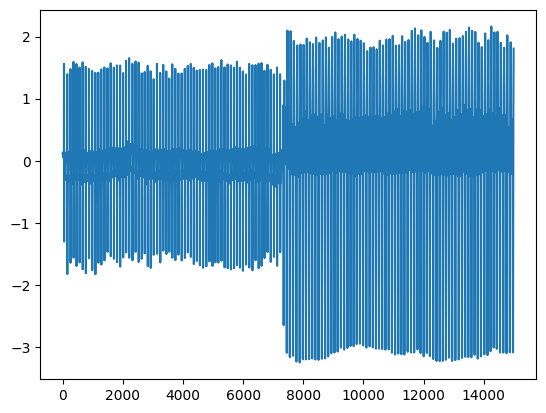

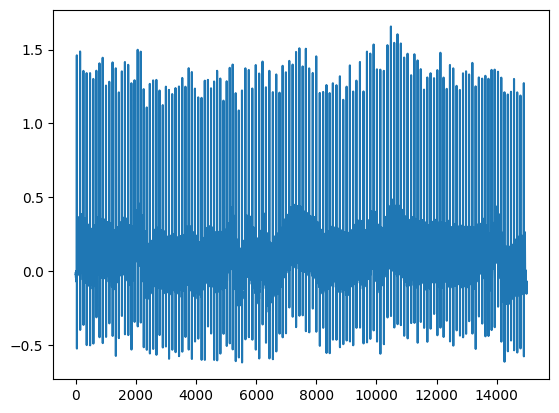

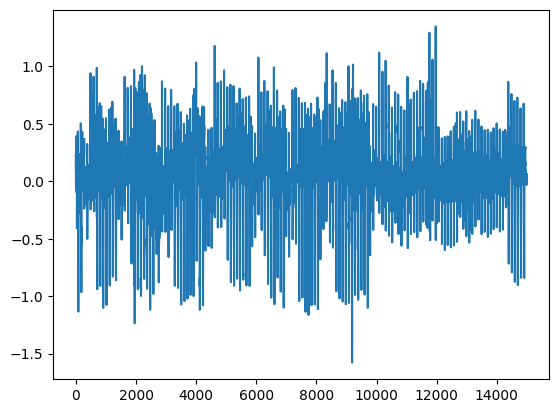

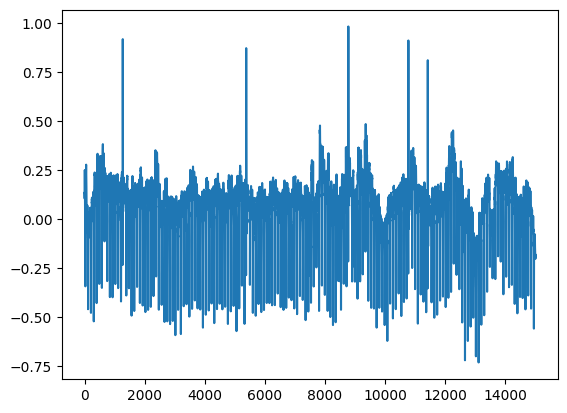

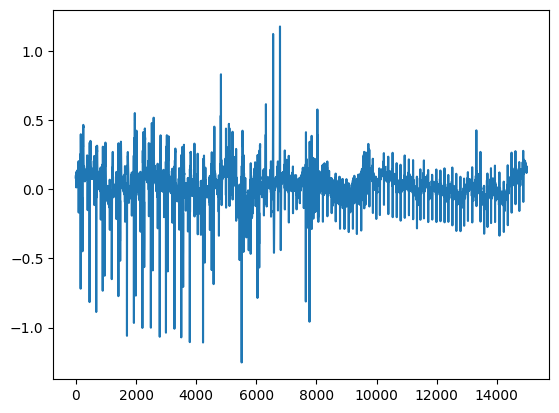

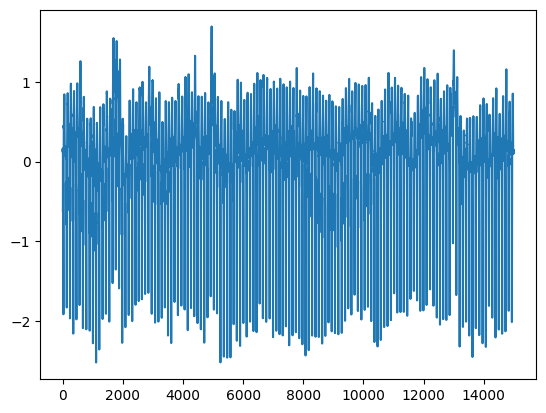

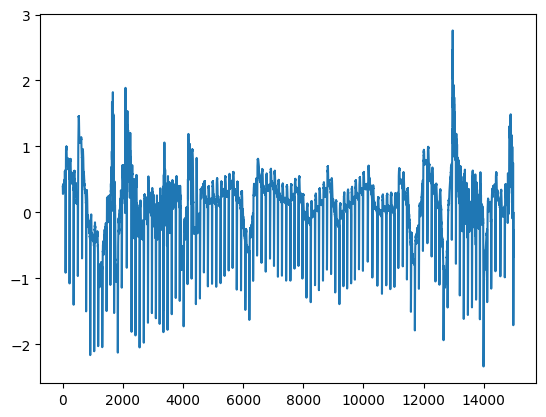

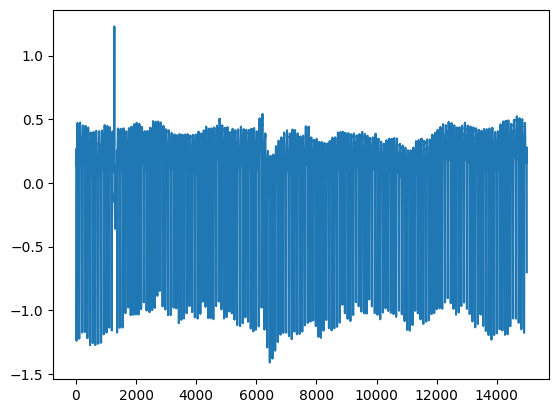

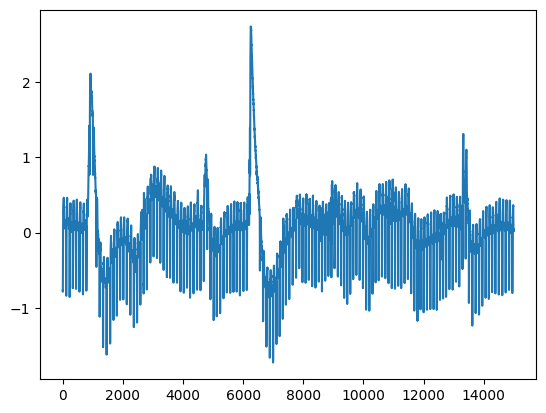

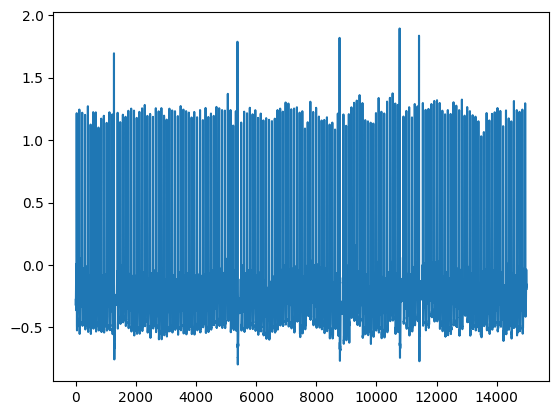

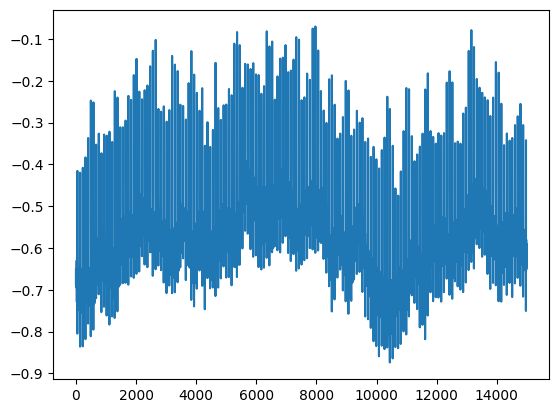

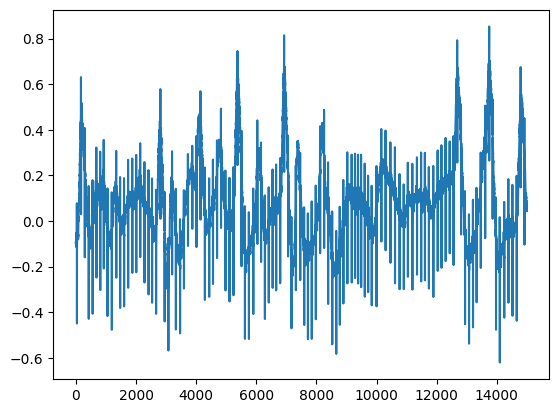

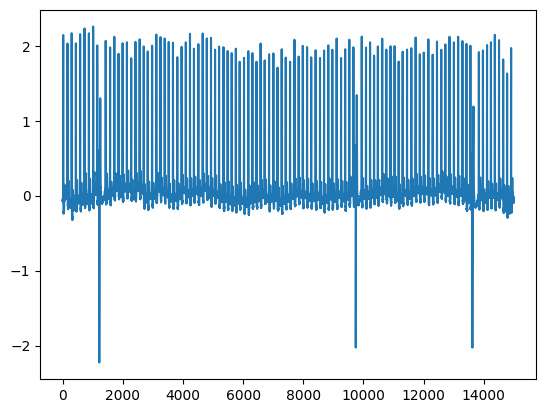

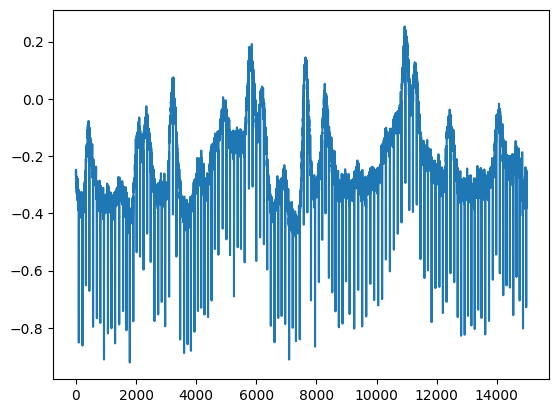

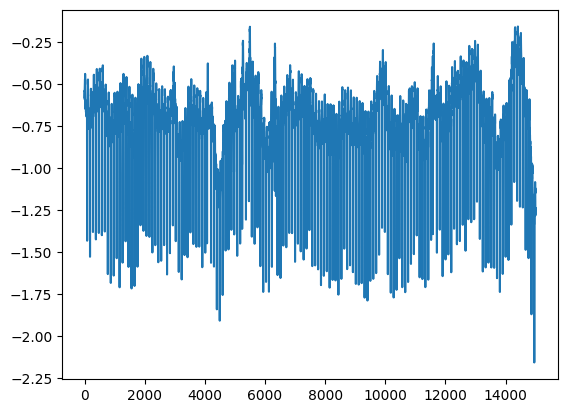

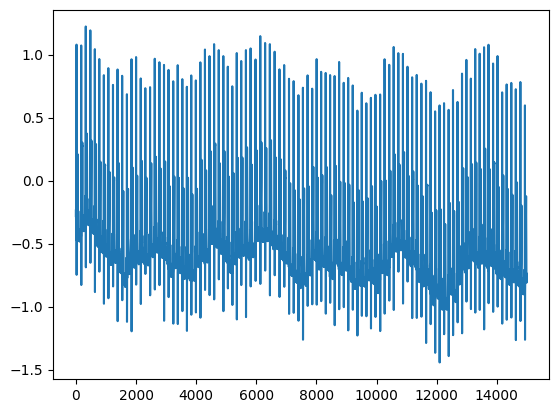

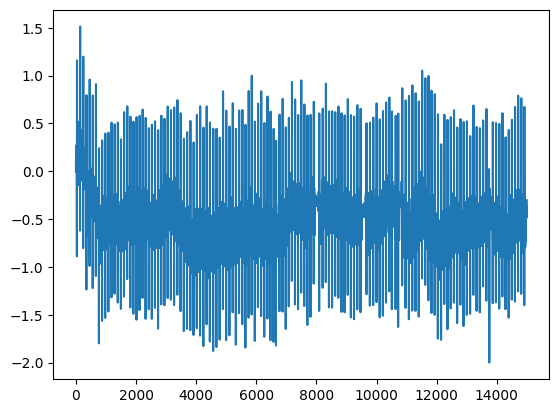

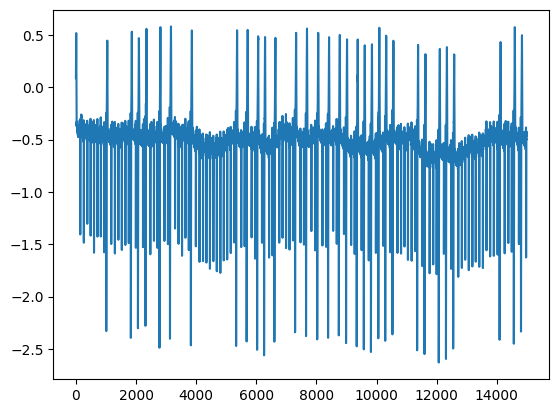

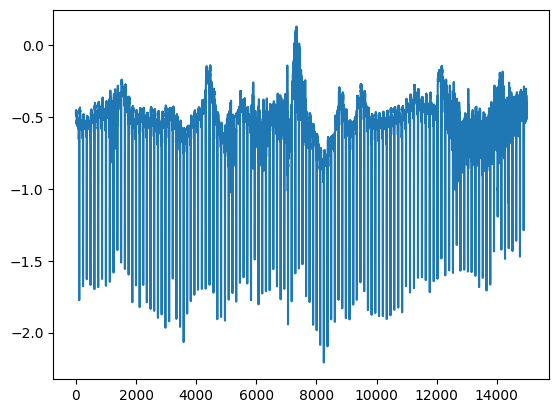

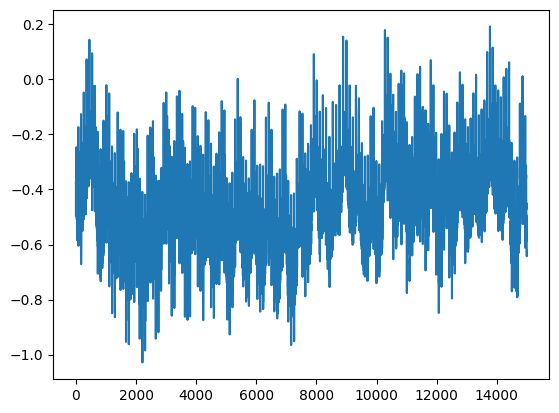

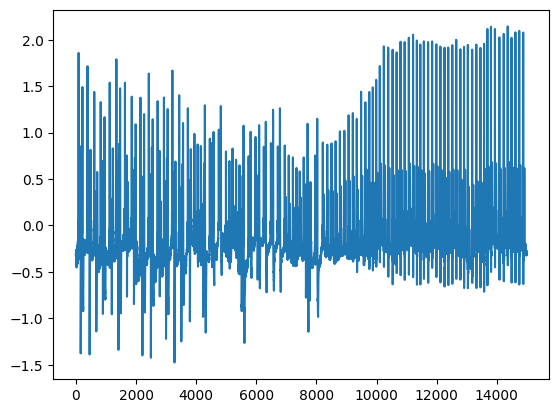

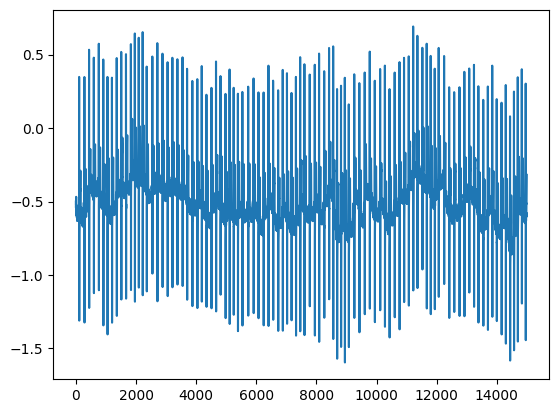

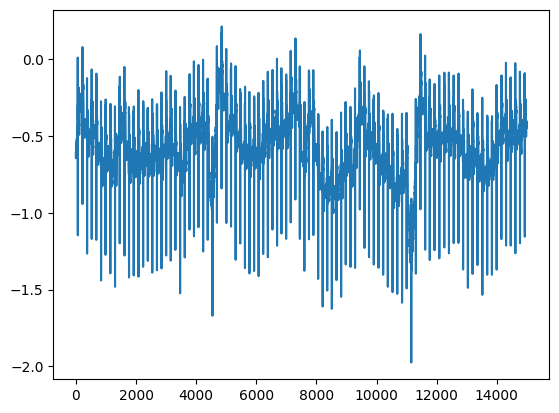

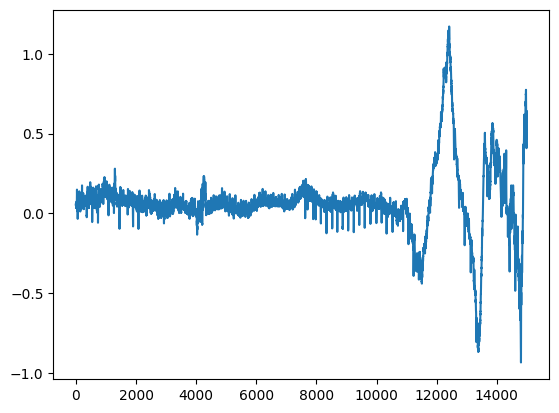

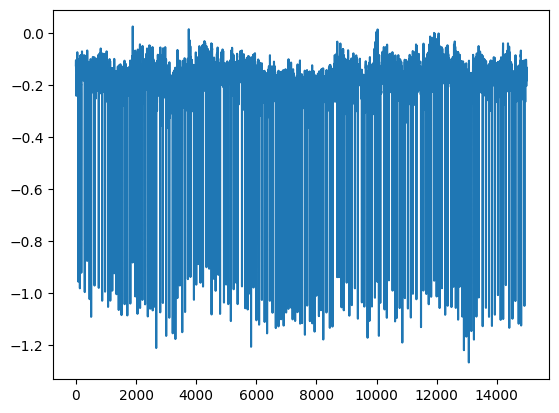

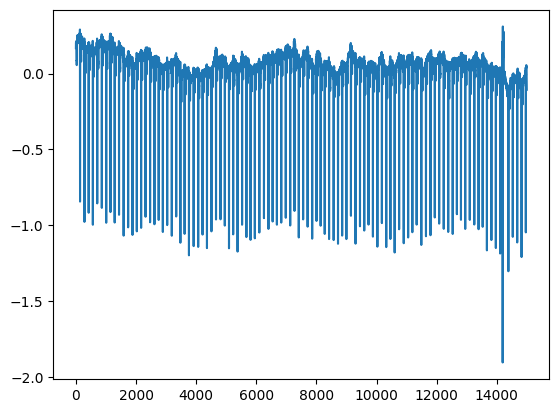

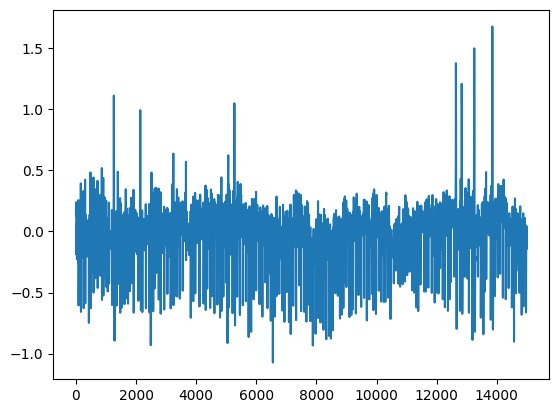

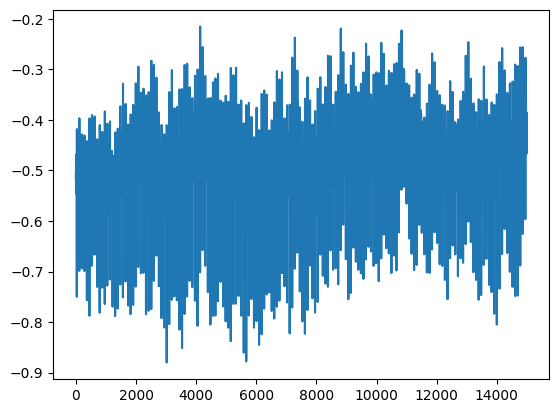

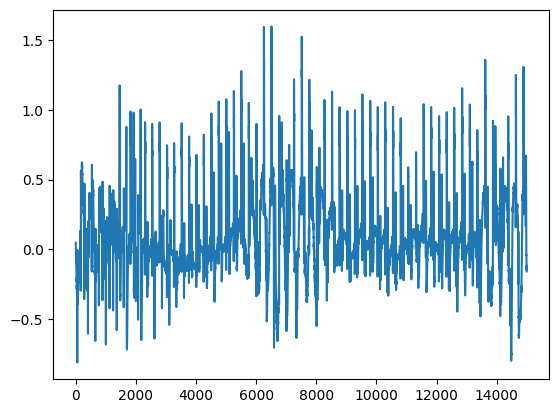

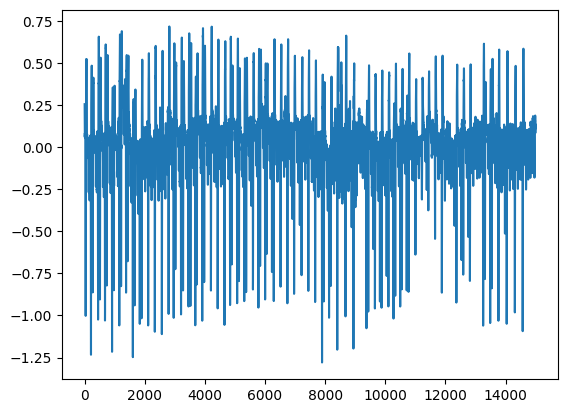

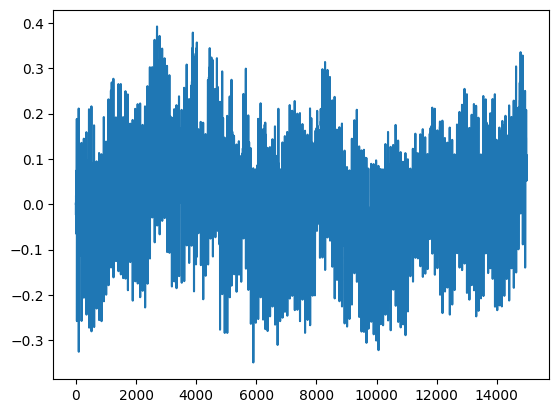

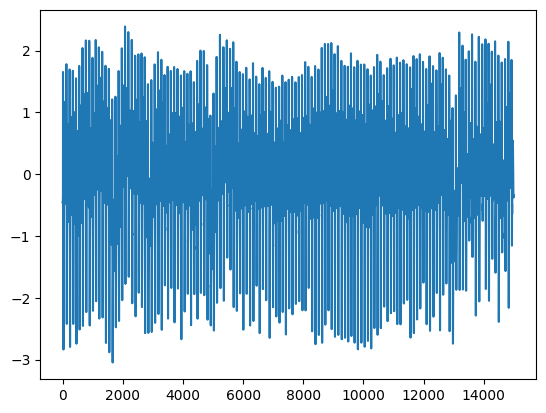

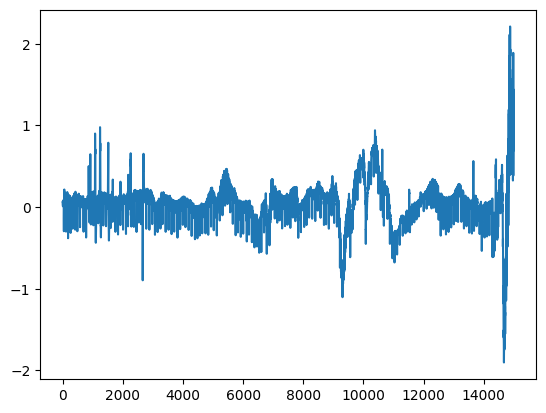

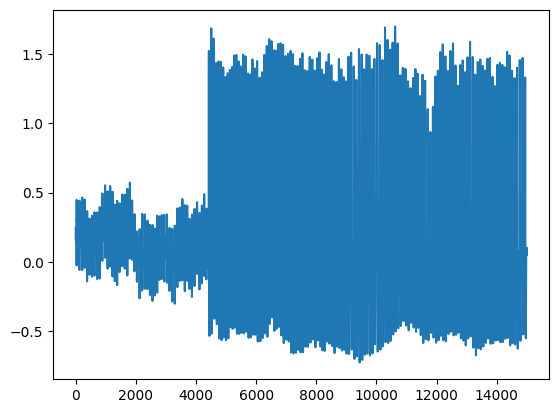

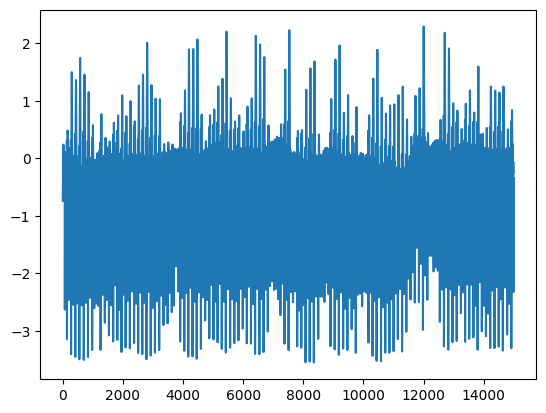

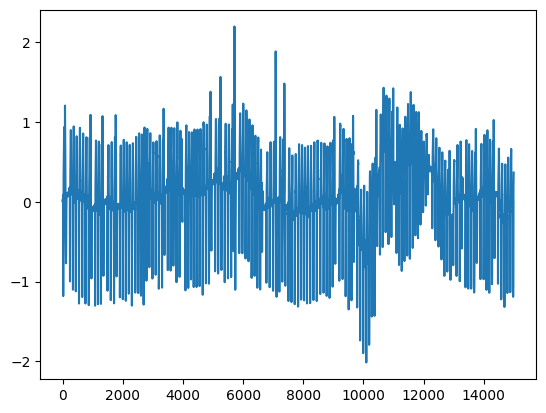

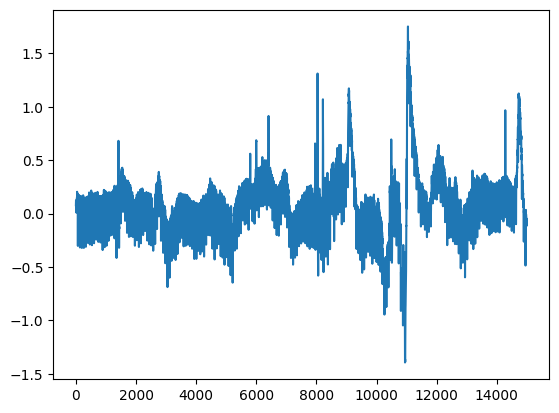

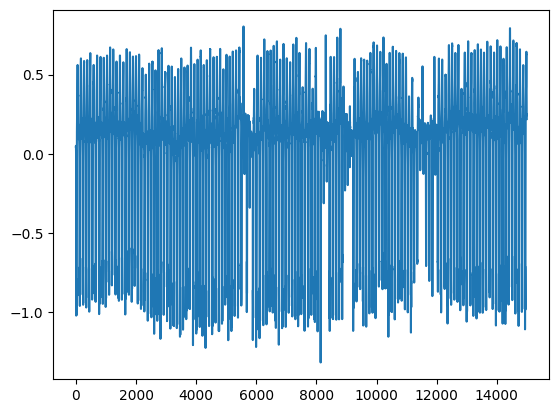

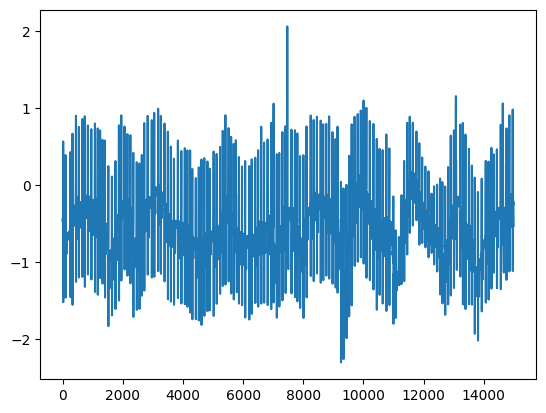

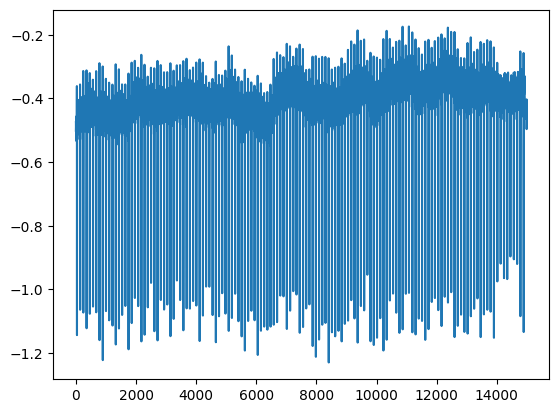

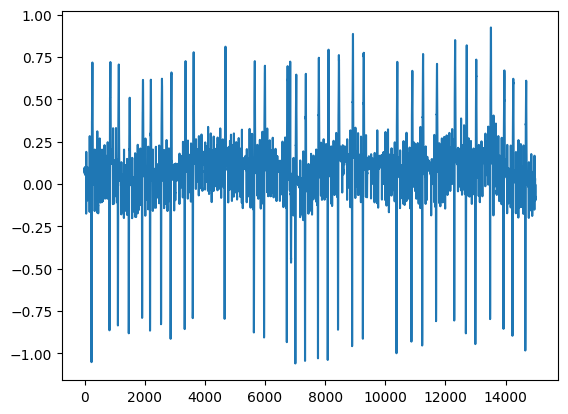

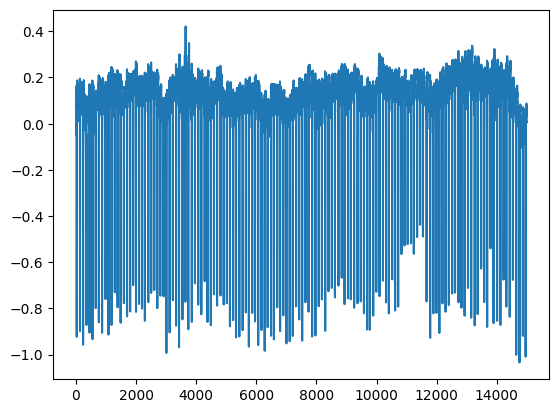

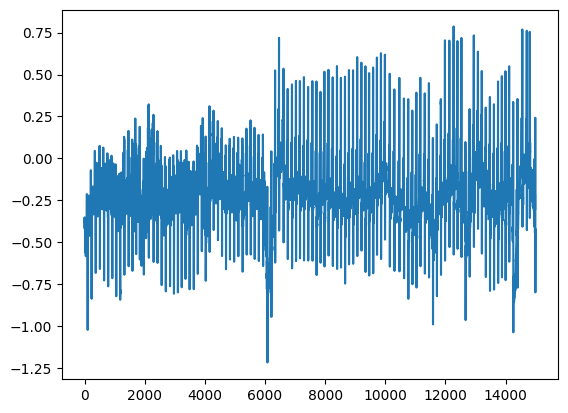

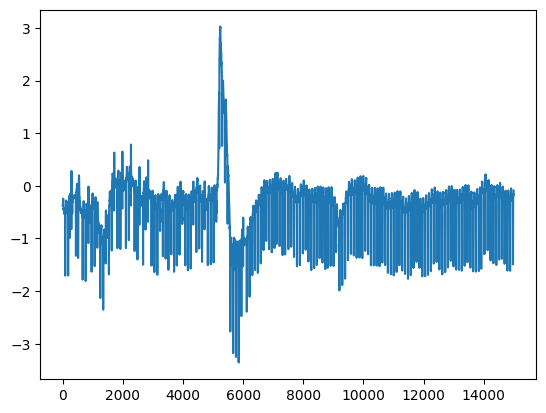

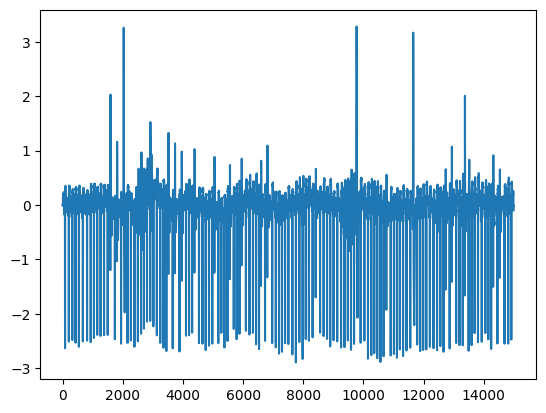

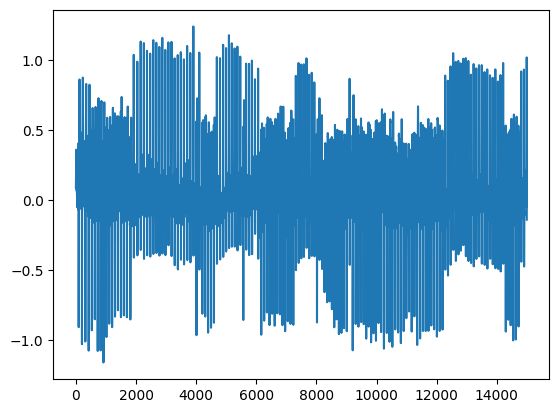

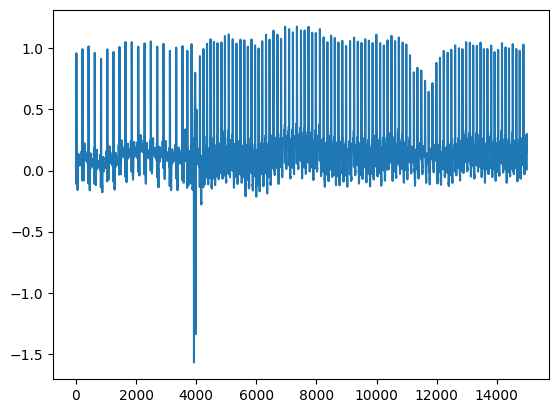

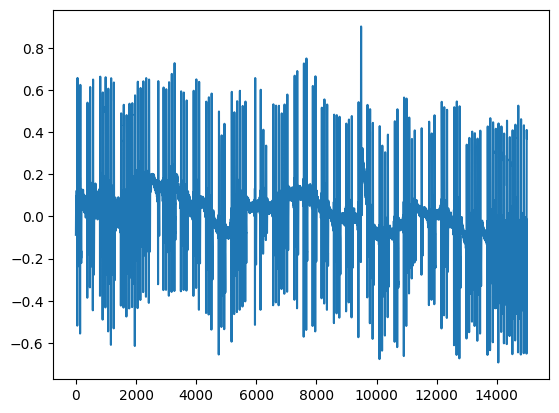

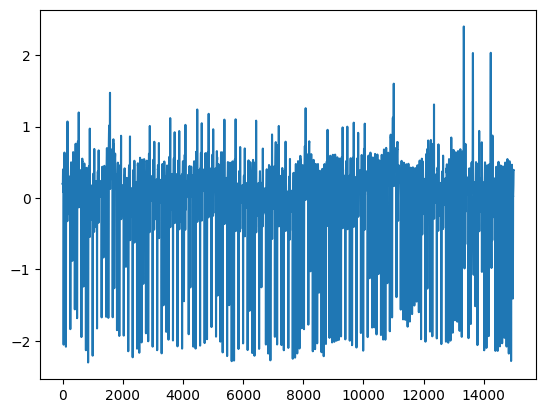

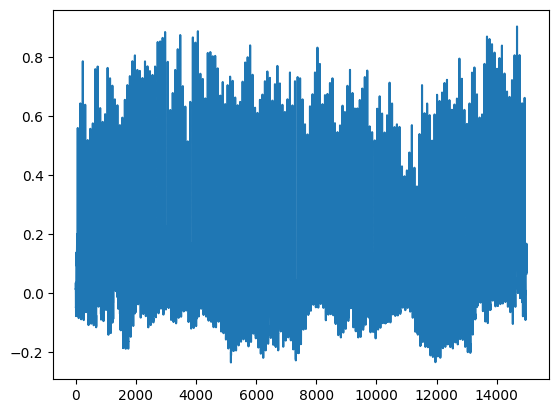

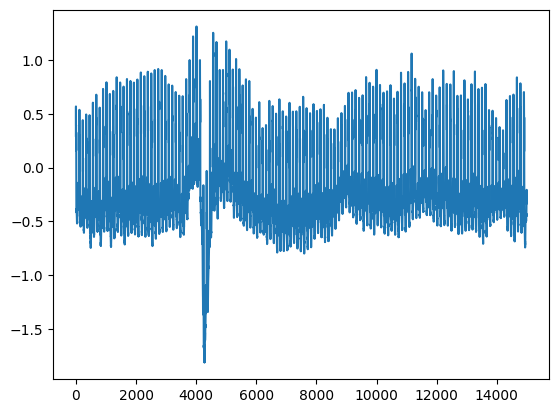

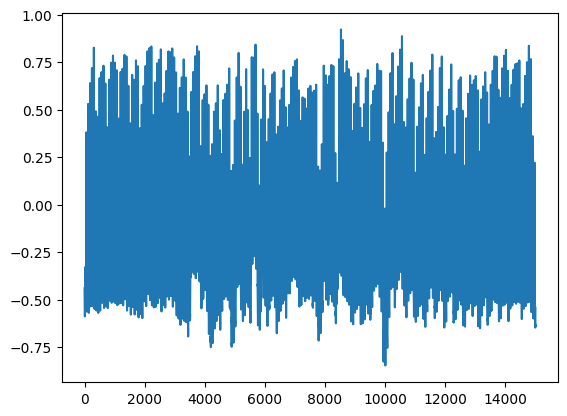

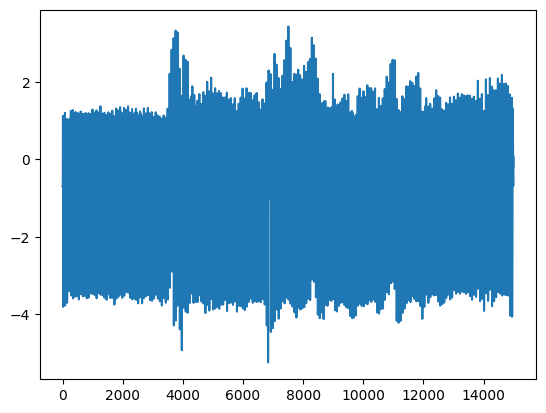

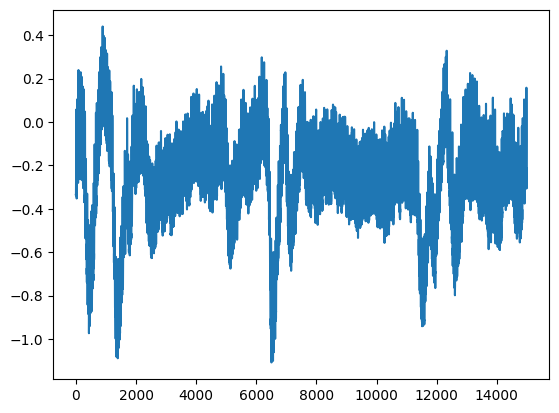

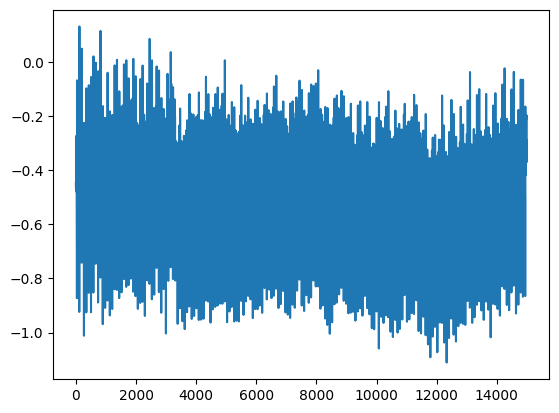

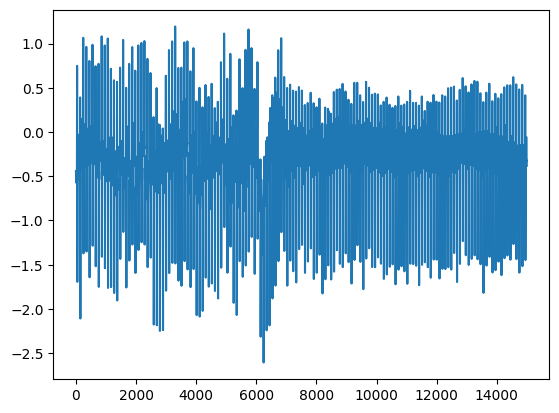

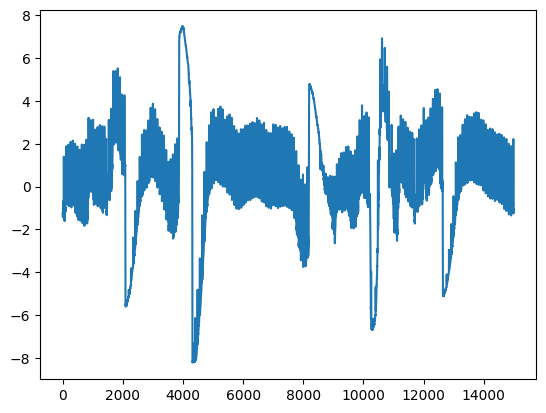

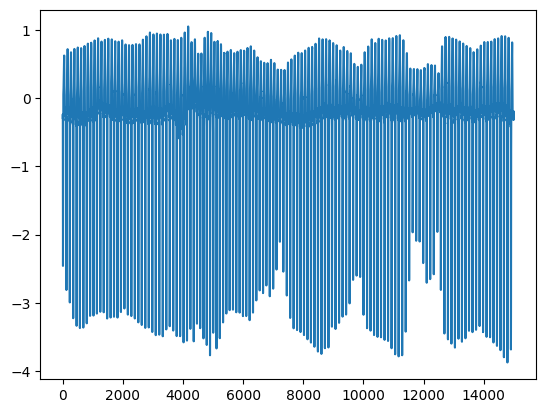

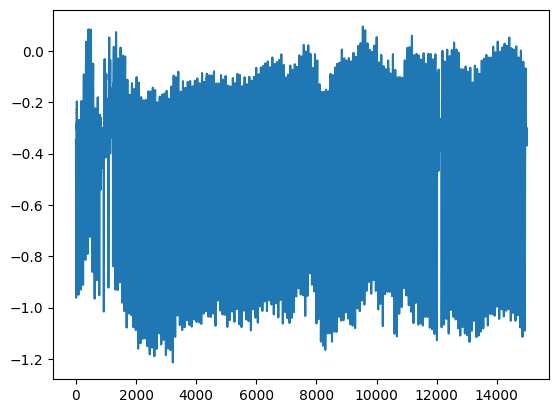

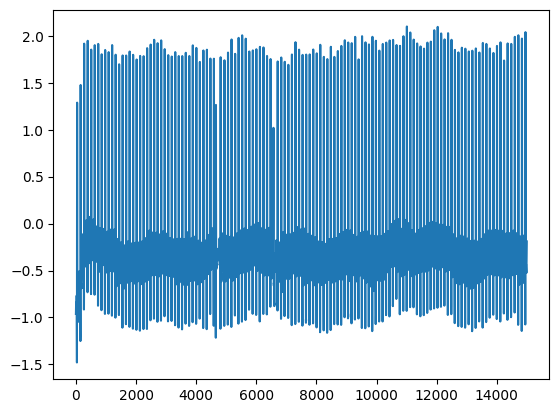

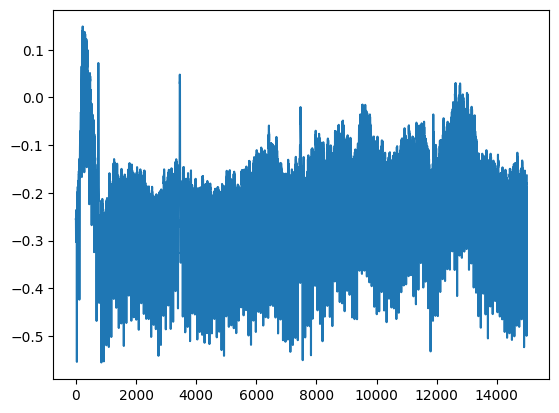

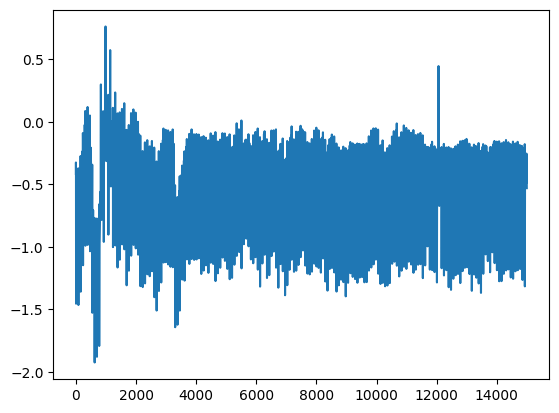

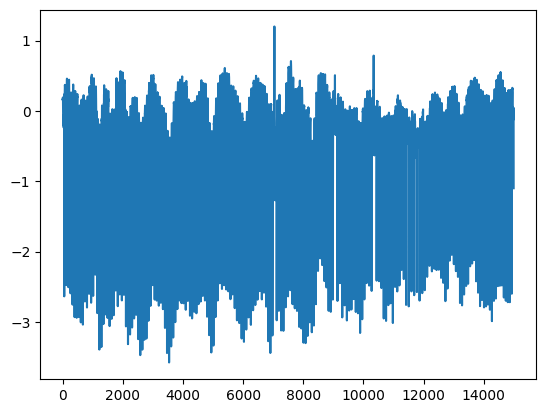

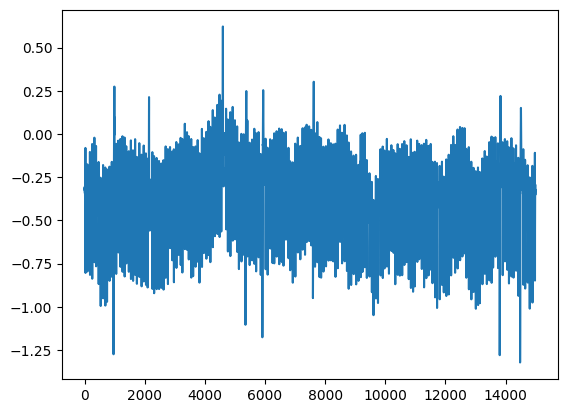

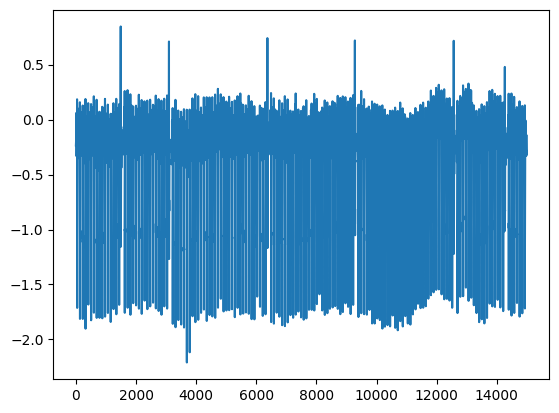

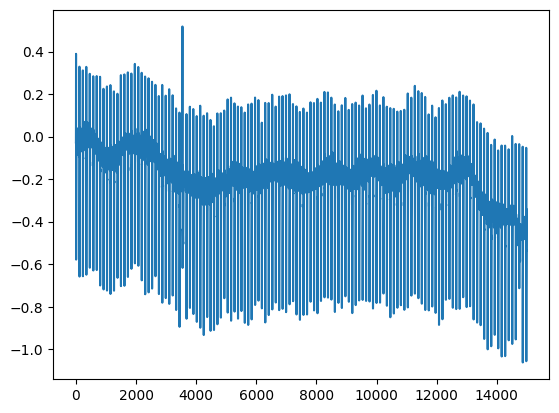

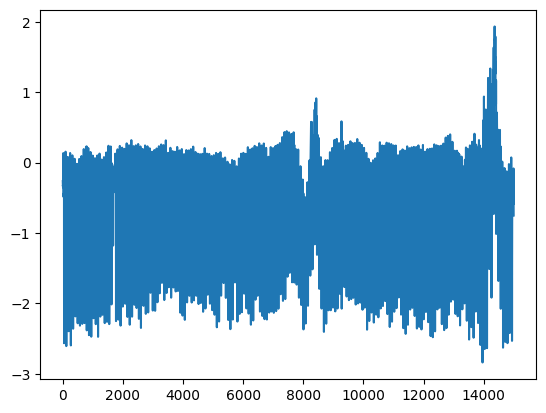

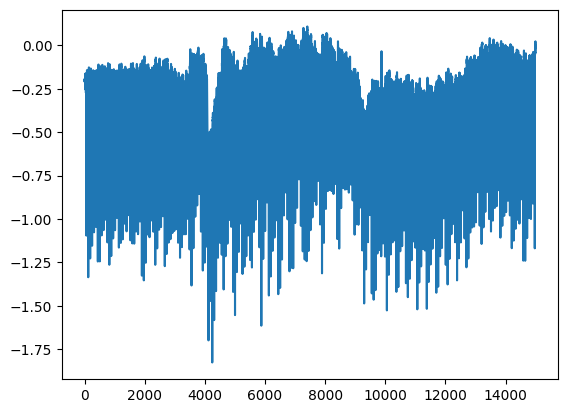

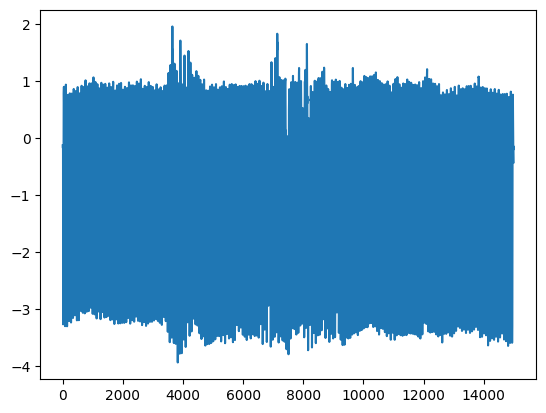

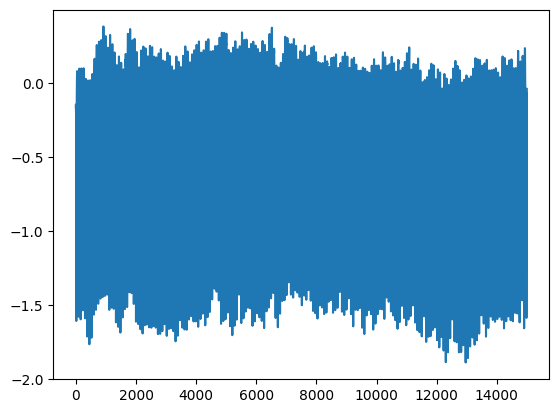

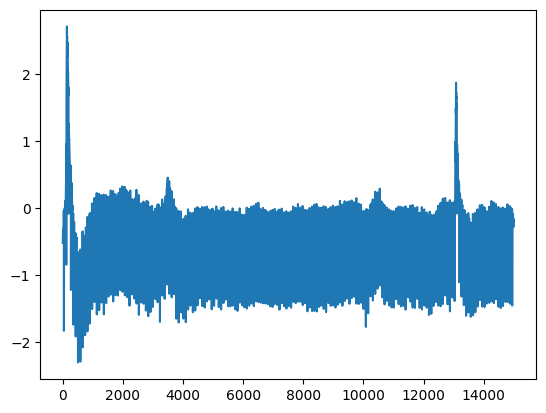

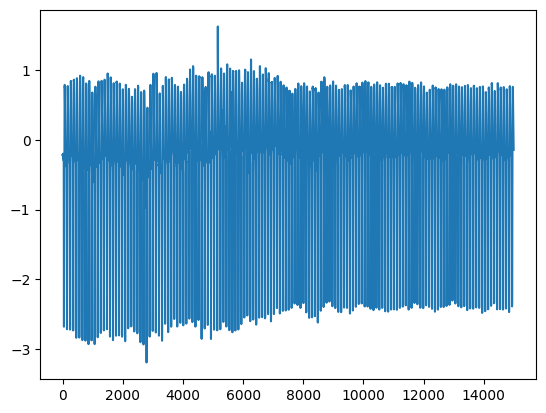

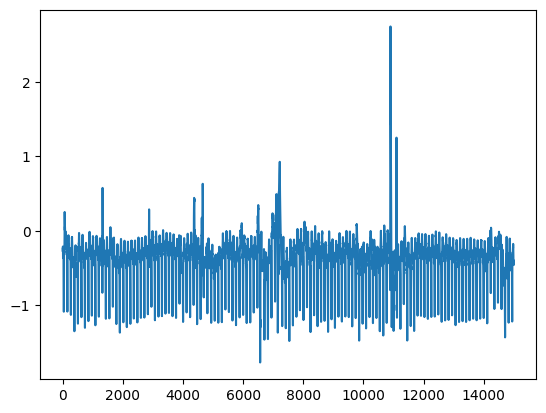

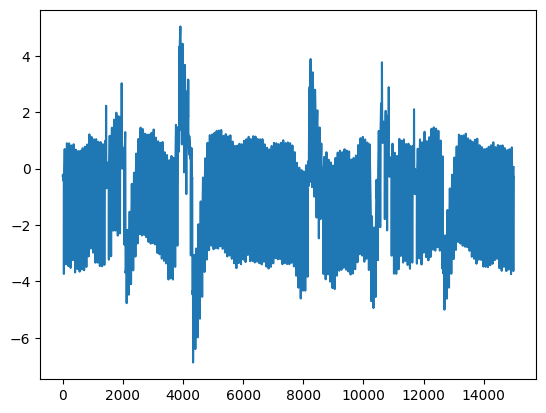

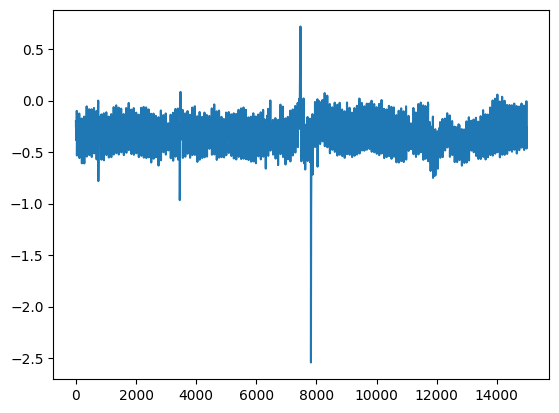

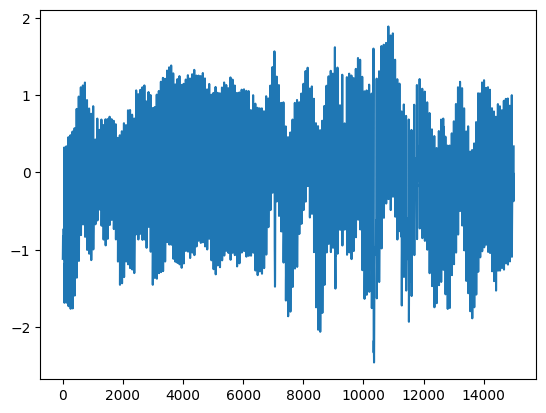

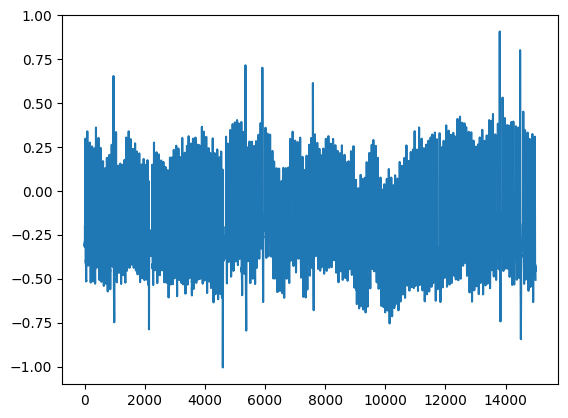

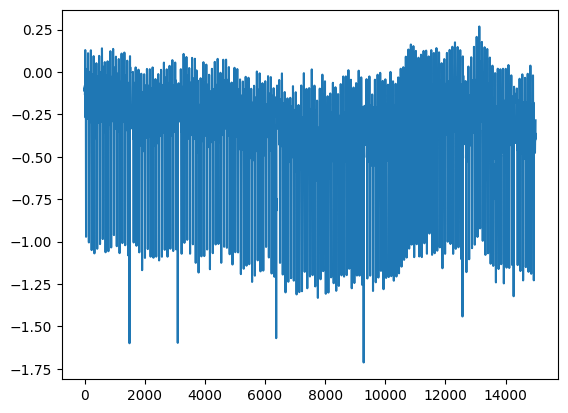

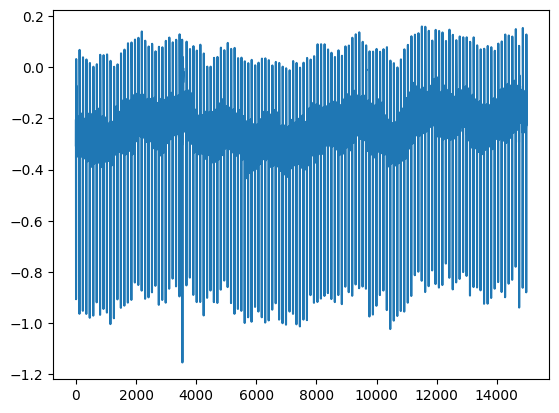

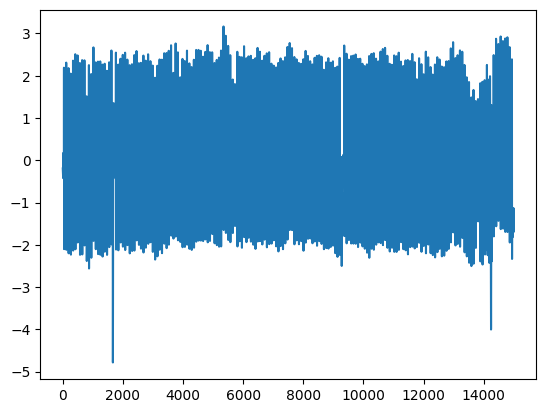

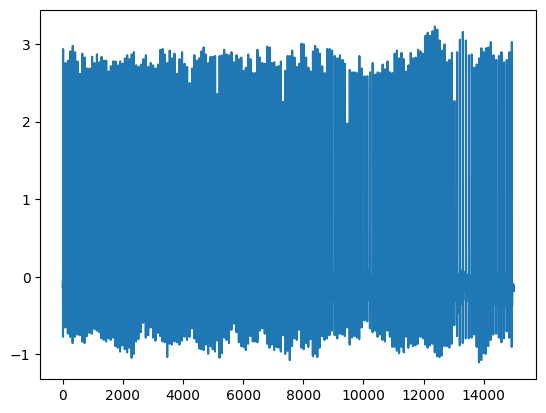

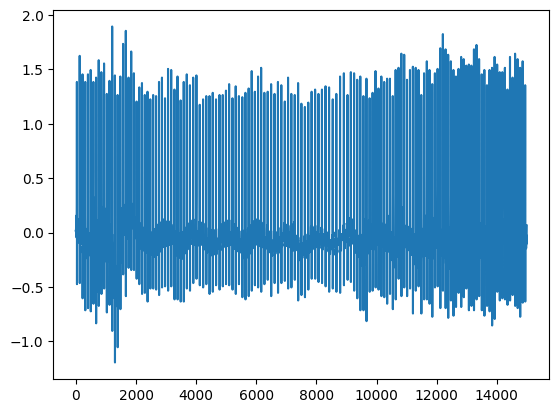

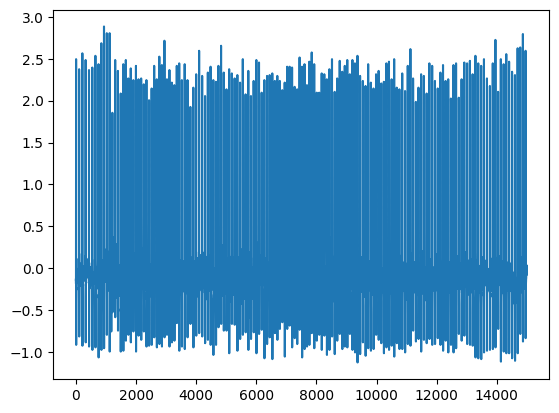

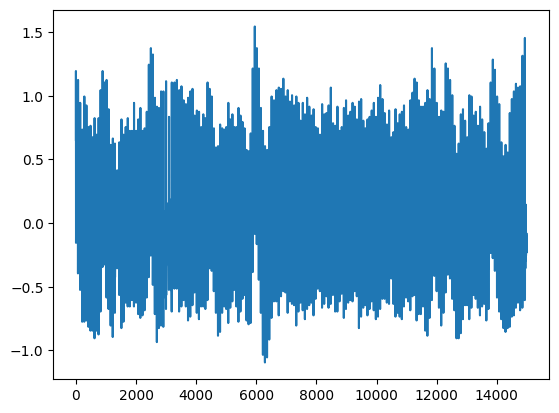

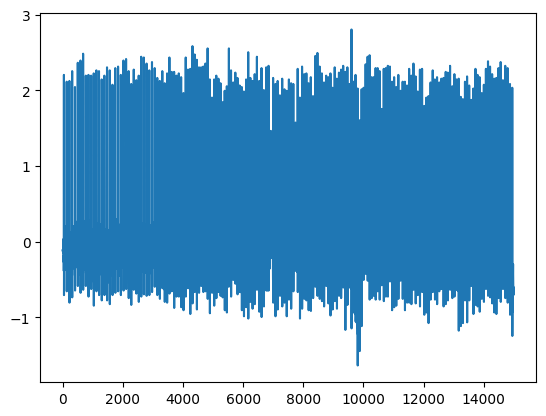

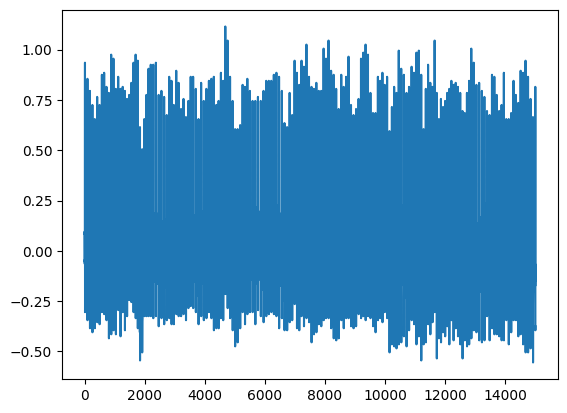

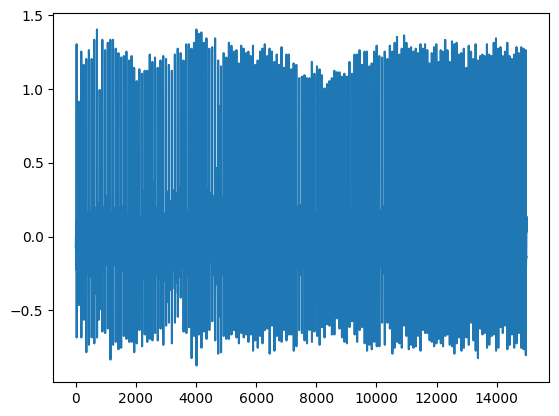

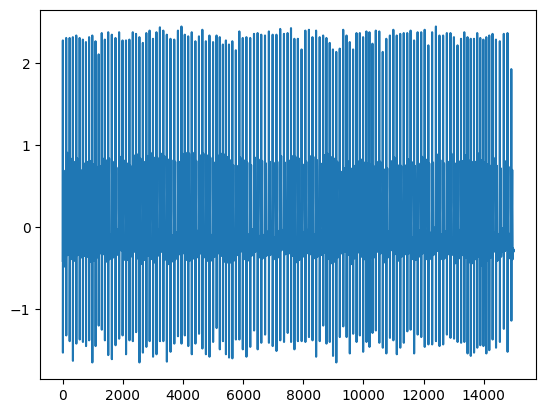

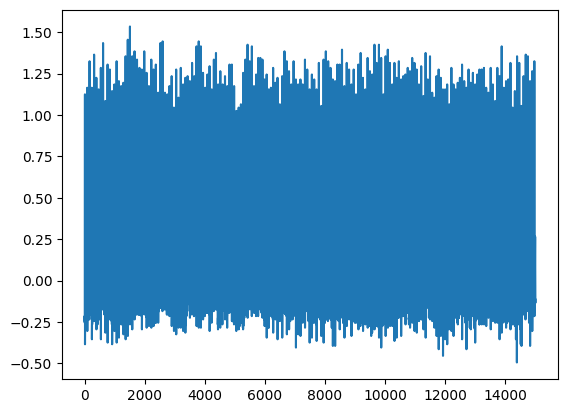

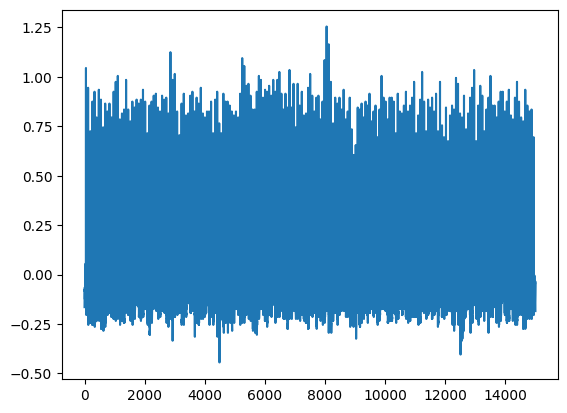

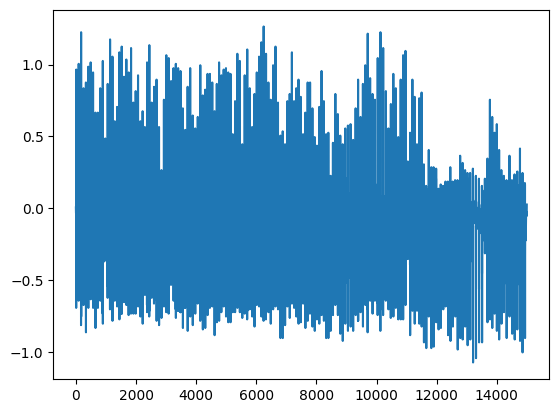

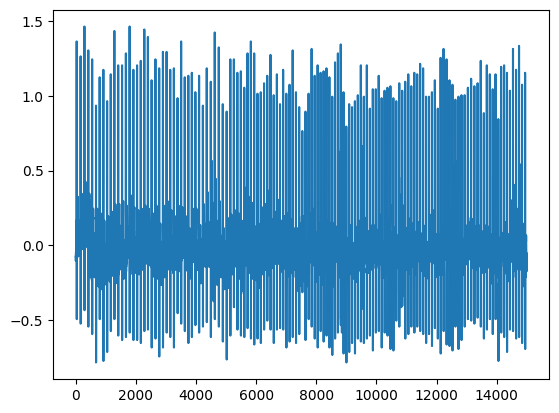

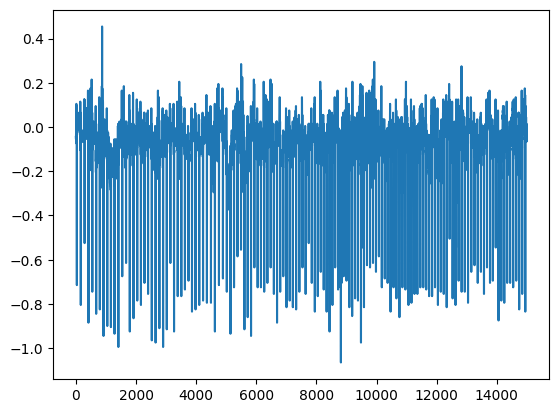

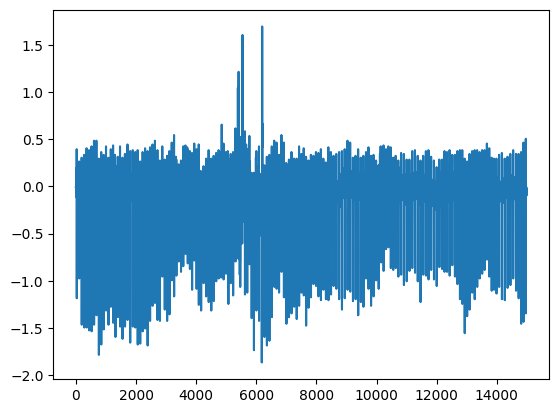

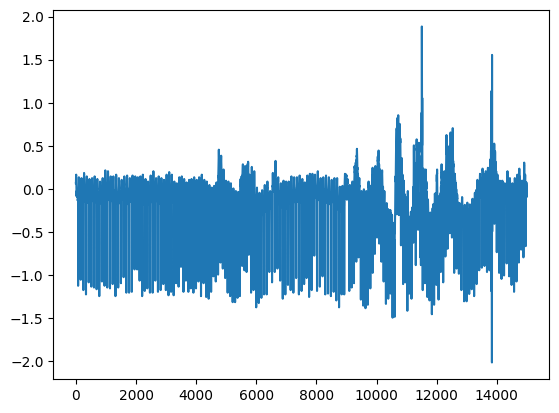

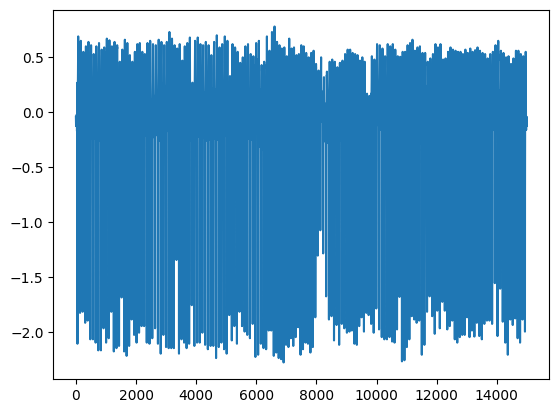

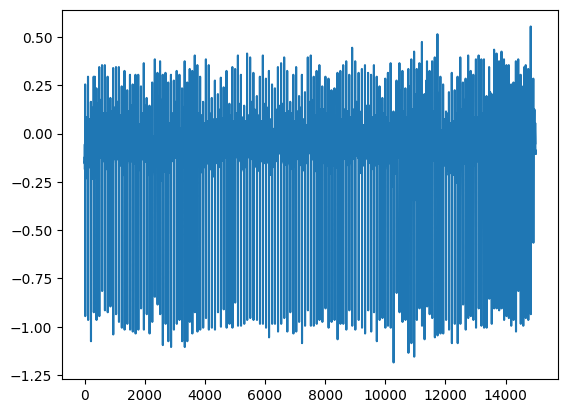

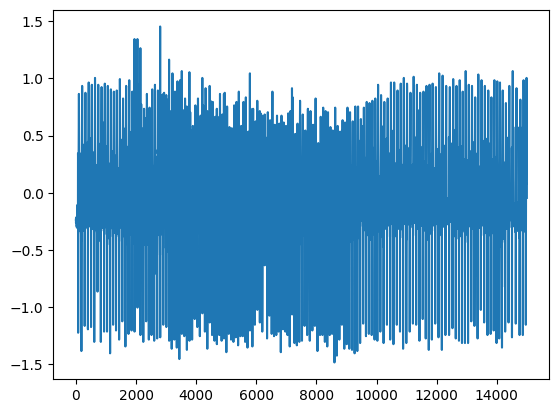

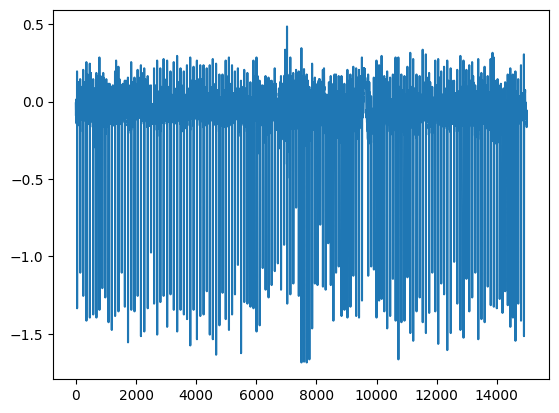

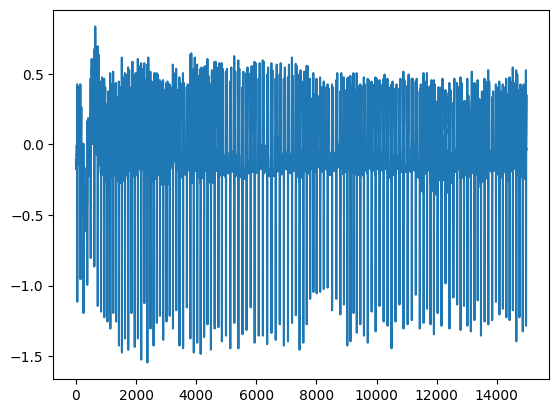

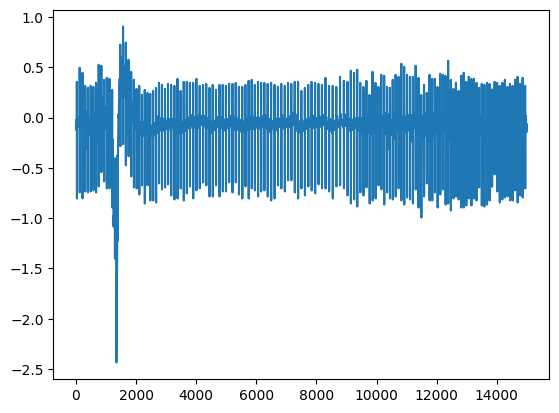

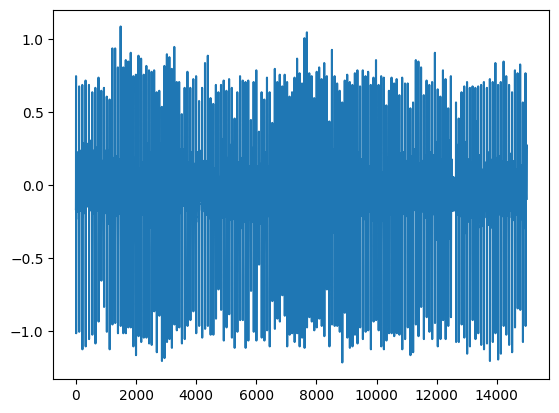

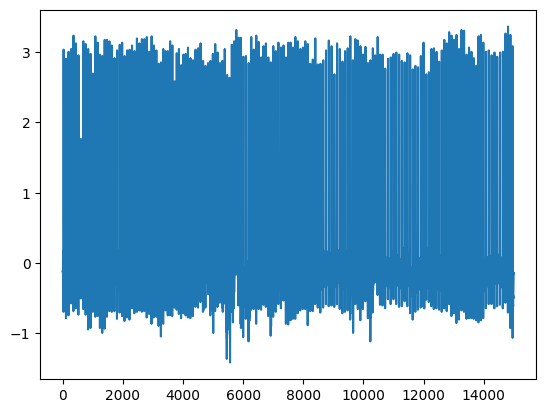

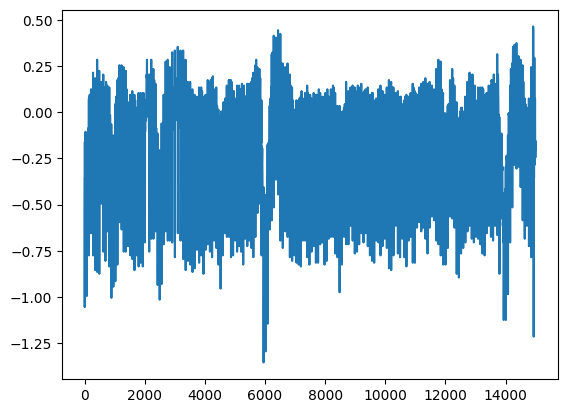

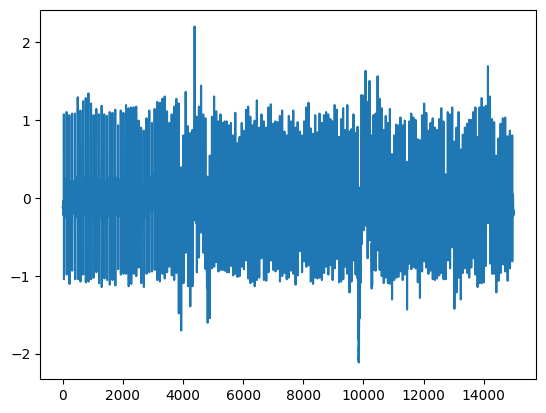

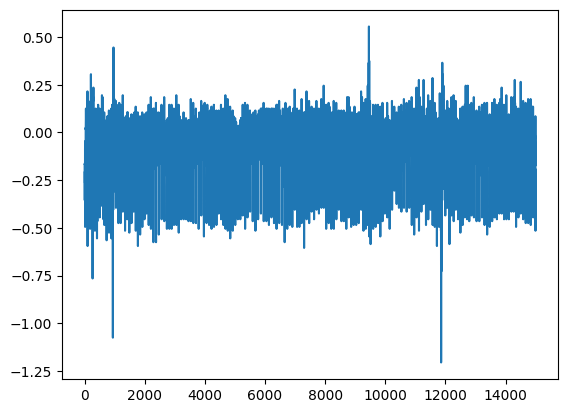

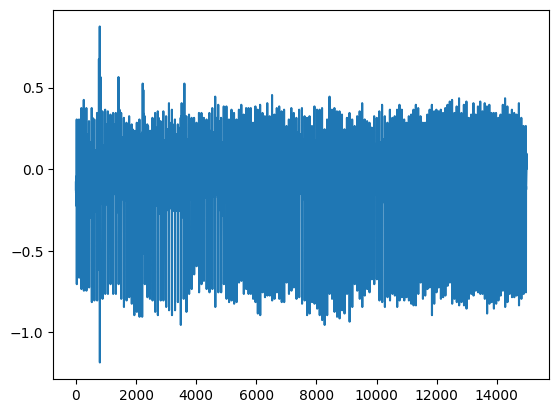

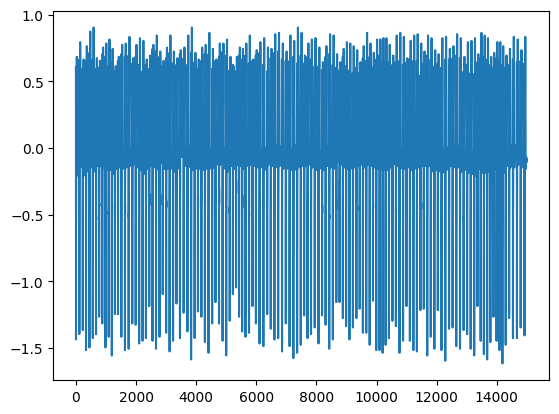

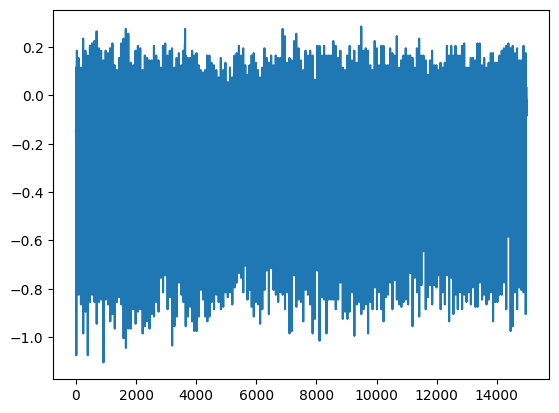

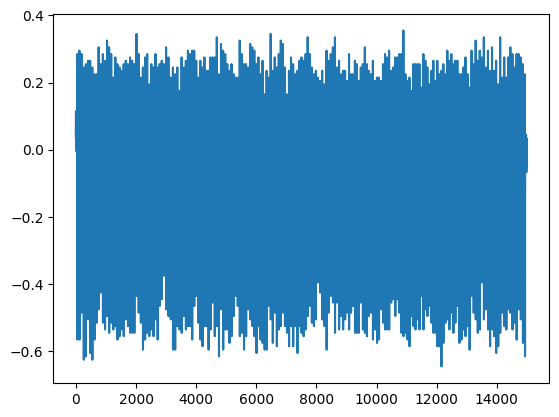

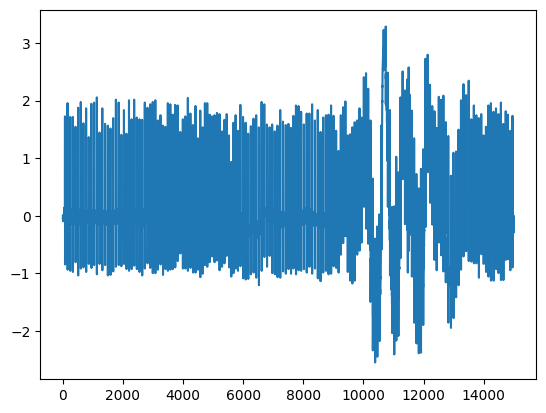

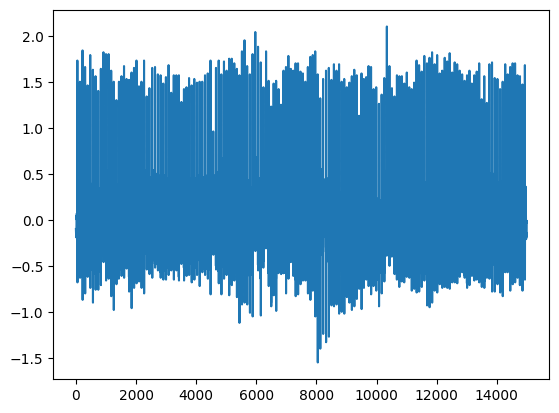

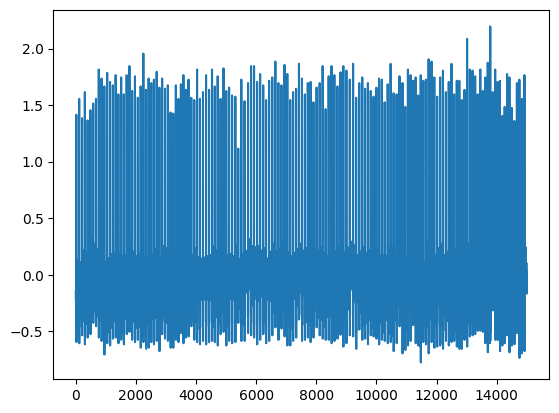

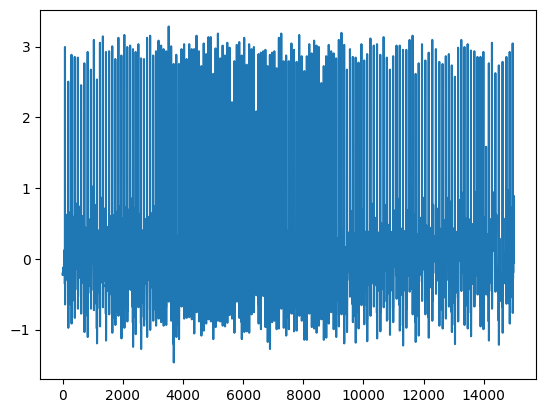

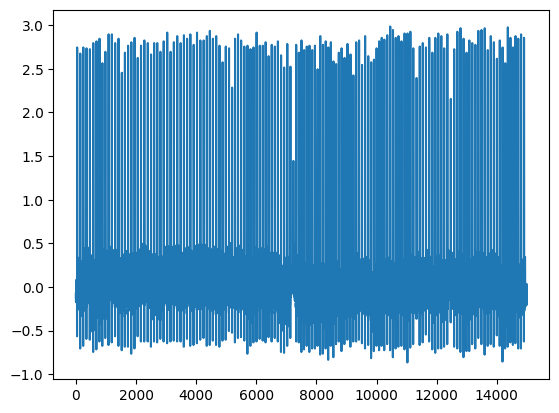

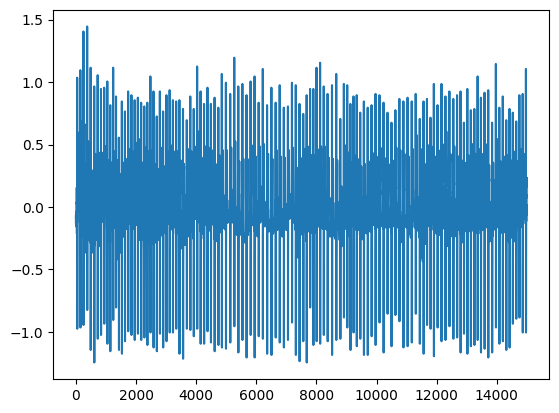

In [ ]:
from ecgdetectors import Detectors

fs = 128
detectors = Detectors(fs)

r_peaks_pan_2D = [];

for i in range(162):
    ecg_unfiltered = x[i,15000:30000]
    r_peaks_pan = detectors.pan_tompkins_detector(ecg_unfiltered)
    r_peaks_pan = np.asarray(r_peaks_pan)
    r_peaks_pan_2D.append(r_peaks_pan)

    plt.figure()
    plt.plot(ecg_unfiltered)
    plt.plot(r_peaks_pan, ecg_unfiltered[r_peaks_pan], 'ro')
    plt.title(f"Sample {i+1}")

### II.4. Feature Extraction
<font color=#6698FF>
Using the successive differences of R peaks function (succ_diffs) allows to calculate the heart rate of each sample. Additionally, calculating the mean square is useful to detect strength of the ECG signal which can help identify cardiac abnormalities. All the features that were extracted take into consideration the R peaks, and are all useful to detect an abnormal heart behavior from a normal one.
</font>

In [ ]:
from hrv import HRV

fs = 128
hrv = HRV(fs)

feature_matrix = np.zeros((162, 11))

for i in range(162):
    # Calculate the successive differences of R peaks
    succ_diffs = hrv._succ_diffs(r_peaks_pan_2D[i])

    # Flatten the array to a 1D array
    succ_diffs = succ_diffs.flatten()
    succ_diffs_max = np.max(succ_diffs)
    succ_diffs_min = np.min(succ_diffs)
    succ_diffs_mean = np.mean(succ_diffs)
    succ_diffs_std = np.std(succ_diffs)

    # Calculate mean square

    rmssd = hrv.RMSSD(r_peaks_pan_2D[i], normalise=True)

    # Calculate standard deviation of successive RR peak differences
    sdsd = hrv.SDSD(r_peaks_pan_2D[i])

    # Calculate heart rates from R peak samples
    hr = hrv.HR(r_peaks_pan_2D[i])
    hr_max = np.max(hr)
    hr_min = np.min(hr)
    hr_mean = np.mean(hr)
    hr_std = np.std(hr)

    # Calculate the number of pairs of successive normal heartbeats that differ by more than 20ms
    nn20 = hrv.NN20(r_peaks_pan_2D[i])

    features = [hr_max,  hr_min, rmssd, nn20, succ_diffs_max, succ_diffs_min, succ_diffs_mean, succ_diffs_std, sdsd, hr_mean, hr_std]
    features = np.asarray(features)

    # Concatenate all the features for each sample into a single row of the feature matrix
    feature_matrix[i] = features

### II.5. Feature Selection


<font color=#6698FF> When using PCA, the most principal components can be extracted. However, we cannot select the best feature with this extraction method. The reason for this is because it makes its 'own feature', which is a combination of the different feautures in order to get the best feature.

In [ ]:
%%capture
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1hB-PsoTWkbj1RKzHPdrd07trrs8HkxBQ

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hB-PsoTWkbj1RKzHPdrd07trrs8HkxBQ
From (redirected): https://drive.google.com/uc?id=1hB-PsoTWkbj1RKzHPdrd07trrs8HkxBQ&confirm=t&uuid=0f710b27-d10f-47c6-84af-fdee14a2e3e2
To: /content/I2ML_week3.py
100% 4.44k/4.44k [00:00<00:00, 11.2MB/s]


In [ ]:
from I2ML_week3 import standard_normalizer
from sklearn.decomposition import PCA

In [ ]:
#Using PCA eigenvalue decomposition to determine principal components
def compute_pca(x,lam):

  #create correlation matrix
  P = float(x.shape[1])
  Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

  #use numpy function to compute eigenvalues
  D,V = np.linalg.eigh(Cov)
  return D,V

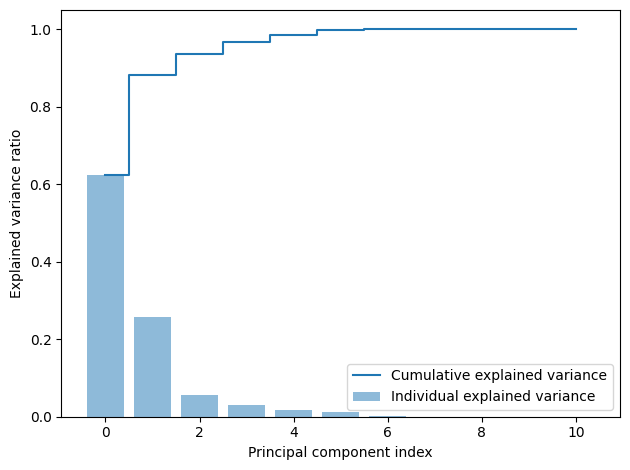

In [ ]:
# normalizing the data
feature_matrix = np.asarray(feature_matrix)
normalizer,inverse_normalizer = standard_normalizer(feature_matrix)
feature_matrix= normalizer(feature_matrix)

#Train PCA
pca = PCA(n_components=11)
pca = pca.fit(feature_matrix)
x_pca_skl = pca.transform(feature_matrix)

x_pca_skl = x_pca_skl [:,0:1]

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### II.6. Classification

<font color=#6698FF> We have tried using the 4 different classification methods: SVM, perceptron, softmax and regularized and we concluded that the best ones for this particular ECG case was to use softmax classification. This was the model we used for the final classification in the next step. </font>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
y=np.asarray(y).flatten()

# Convert the strings of the y data into integers
y[y=='CHF']=0
y[y=='NSR']=1
y[y=='ARR']=2

y=y.astype("int")

# Split the data into 70% training set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.3, shuffle = True)

In [ ]:
# Convert y into numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Create the classifiers
svm_classifier = SVC(kernel='linear', C=1, random_state=42)
perceptron_classifier = Perceptron(alpha=0.0001, max_iter=1000, random_state=42)
softmax_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
reg_classifier = LogisticRegression(penalty='l2', C=1, max_iter=1000, random_state=42)

# Train the classifiers on the training set
svm_classifier.fit(X_train, y_train)
perceptron_classifier.fit(X_train, y_train)
softmax_classifier.fit(X_train, y_train)
reg_classifier.fit(X_train, y_train)

# Predict the labels of the testing set using the classifiers
svm_y_pred = svm_classifier.predict(X_test)
perceptron_y_pred = perceptron_classifier.predict(X_test)
softmax_y_pred = softmax_classifier.predict(X_test)
reg_y_pred = reg_classifier.predict(X_test)

# Evaluate the performance of the classifiers on the testing set
svm_accuracy = accuracy_score(y_test, svm_y_pred)
perceptron_accuracy = accuracy_score(y_test, perceptron_y_pred)
softmax_accuracy = accuracy_score(y_test, softmax_y_pred)
reg_accuracy = accuracy_score(y_test, reg_y_pred)

# Print the accuracy scores of all classifiers
print("SVM Accuracy:", svm_accuracy)
print("Perceptron Accuracy:", perceptron_accuracy)
print("Softmax Accuracy:", softmax_accuracy)
print("Regularized Classifier Accuracy:", reg_accuracy)

# Identify the best classifier based on accuracy score
classifiers = [svm_accuracy, perceptron_accuracy, softmax_accuracy, reg_accuracy]
classifier_names = ['SVM', 'Perceptron', 'Softmax', 'Logistic Regression']

best_accuracy = max(classifiers)
index = classifiers.index(best_accuracy)
best_classifier = classifier_names[index]

print("Best classifier:",best_classifier, "Accurary:", best_accuracy)

SVM Accuracy: 0.6122448979591837
Perceptron Accuracy: 0.5510204081632653
Softmax Accuracy: 0.6122448979591837
Regularized Classifier Accuracy: 0.6122448979591837
Best classifier: SVM Accurary: 0.6122448979591837



## III. Results
<font color=#6698FF> We observe a poor confusion matrix. For value 2, the model predicts it 26 times correctly, but 2 times incorrectly, which is a fair model performance. However, for value 1, it predicts it only 2 times correctly and 8 times incorrectly and for value 0, false predictions are also higher than accurate predictions (5 times false VS 3 times correct. This makes the overall performance of the model weak. A few possible causes for this could be: poor feature selection, overfitting or insufficient training data.</font>

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [ ]:
#standard normalize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define softmax as model
model = svm_classifier;

# Fit the model
model.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=42)

In [ ]:
# Predict outputs
y_pred = model.predict(X_test)

# accuracy
score = model.score(X_test, y_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[ 1  1  8]
 [ 1  3  4]
 [ 1  3 27]]


In [ ]:
import seaborn as sns

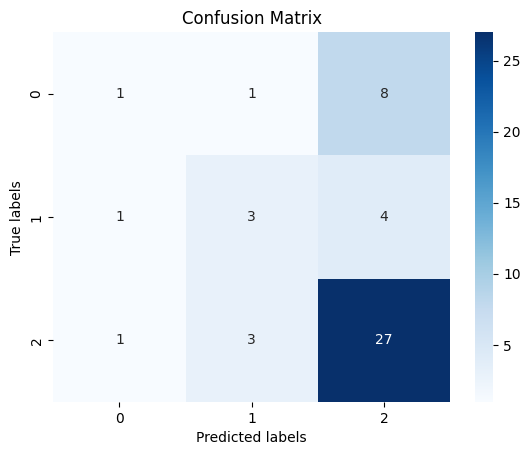

In [ ]:
sns.heatmap(cm, annot=True, cmap="Blues")

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## IV. Discussion and Conclusion

<font color=#6698FF>
- We did not use the filtered data during the feature extraction, we only used the R peaks data, which might make the results less accurate
- When we performed R peak detection, we only selected samples from the middle of the interval and discarded aberrant values in the beginning or in the end of the interval
- There are parts in the code that have been commented for the sake of running the code faster, but can be decommented if you want to visualize the plots of the 162 ECG samples and the R peaks.
- We could have extracted better features (e.g. ones that involve using the filtered data samples instead of the R peaks)
- Since we have only used 11 features, we did not really use PCA as it is not as useful as if we had a larger number of features
- The overall performance of the confusion matrix was not good as we should have only obtained accurate scores on the diagonal of the matrix. </font>